In [1]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP 
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

Matplotlib is building the font cache using fc-list. This may take a moment.


# Config

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [3]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [4]:
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

In [ ]:
# sample_test = np.expand_dims(toy_data.inf_train_gen('pinwheel', n_points=4096), 0)

In [ ]:
# sampled_perturbed = sample_test + np.random.randn(*sample_test.shape) * np_sigmas[..., None, None]

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# idx = 1
# plt.scatter(sampled_perturbed[idx, :, 0], sampled_perturbed[idx, :, 1])

# Training

In [5]:
score_net = SmallMLP(in_dim=2)
critic_net = SmallMLP(in_dim=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 15000
itr = 0

losses = []
sigmas = sigmas[1:]
for epoch in range(epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    tr_pts = sample_data('pinwheel', 2048).view(-1, 2)
    tr_pts.requires_grad_()
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    
    losses.append(loss)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    
    cycle_iter = itr % (k_iters + e_iters)
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

Epoch 0 (critic), Loss=-0.01604 t1=0.01269 t2=-0.02873
Epoch 1 (critic), Loss=0.22349 t1=0.00247 t2=0.22102
Epoch 2 (critic), Loss=0.43719 t1=-0.00790 t2=0.44510
Epoch 3 (critic), Loss=0.58781 t1=-0.01462 t2=0.60243
Epoch 4 (critic), Loss=0.64637 t1=-0.01826 t2=0.66463
Epoch 5 (score), Loss=0.63373 t1=-0.02021 t2=0.65394
Epoch 6 (critic), Loss=0.45094 t1=-0.20441 t2=0.65536
Epoch 7 (critic), Loss=0.40155 t1=-0.17917 t2=0.58072
Epoch 8 (critic), Loss=0.33354 t1=-0.14578 t2=0.47932
Epoch 9 (critic), Loss=0.26144 t1=-0.11107 t2=0.37251
Epoch 10 (critic), Loss=0.19668 t1=-0.07965 t2=0.27633
Epoch 11 (score), Loss=0.14851 t1=-0.05590 t2=0.20442
Epoch 12 (critic), Loss=0.10042 t1=-0.10350 t2=0.20392
Epoch 13 (critic), Loss=0.07545 t1=-0.06513 t2=0.14058
Epoch 14 (critic), Loss=0.05700 t1=-0.03874 t2=0.09574
Epoch 15 (critic), Loss=0.04800 t1=-0.02418 t2=0.07218
Epoch 16 (critic), Loss=0.04593 t1=-0.01853 t2=0.06446
Epoch 17 (score), Loss=0.05300 t1=-0.02304 t2=0.07604
Epoch 18 (critic), Loss

Epoch 158 (critic), Loss=1.38088 t1=-0.04316 t2=1.42404
Epoch 159 (critic), Loss=1.47957 t1=0.01026 t2=1.46932
Epoch 160 (critic), Loss=1.48443 t1=0.04214 t2=1.44229
Epoch 161 (score), Loss=1.53941 t1=0.04820 t2=1.49121
Epoch 162 (critic), Loss=1.54110 t1=0.02940 t2=1.51170
Epoch 163 (critic), Loss=1.53753 t1=0.01181 t2=1.52572
Epoch 164 (critic), Loss=1.56624 t1=-0.02955 t2=1.59579
Epoch 165 (critic), Loss=1.61582 t1=-0.05692 t2=1.67274
Epoch 166 (critic), Loss=1.58855 t1=-0.01402 t2=1.60257
Epoch 167 (score), Loss=1.62058 t1=0.04707 t2=1.57351
Epoch 168 (critic), Loss=1.63926 t1=0.06137 t2=1.57789
Epoch 169 (critic), Loss=1.67195 t1=0.02677 t2=1.64518
Epoch 170 (critic), Loss=1.67552 t1=-0.04086 t2=1.71639
Epoch 171 (critic), Loss=1.71500 t1=-0.03376 t2=1.74876
Epoch 172 (critic), Loss=1.72216 t1=0.01086 t2=1.71130
Epoch 173 (score), Loss=1.75691 t1=0.04035 t2=1.71656
Epoch 174 (critic), Loss=1.69292 t1=-0.00206 t2=1.69498
Epoch 175 (critic), Loss=1.75907 t1=-0.01573 t2=1.77480
Epoch

Epoch 309 (critic), Loss=4.74389 t1=-0.14337 t2=4.88726
Epoch 310 (critic), Loss=4.71358 t1=-0.12049 t2=4.83407
Epoch 311 (score), Loss=4.75001 t1=-0.18285 t2=4.93286
Epoch 312 (critic), Loss=4.81206 t1=-0.16476 t2=4.97682
Epoch 313 (critic), Loss=4.88642 t1=-0.23828 t2=5.12470
Epoch 314 (critic), Loss=4.89701 t1=-0.21342 t2=5.11043
Epoch 315 (critic), Loss=4.77284 t1=-0.12641 t2=4.89926
Epoch 316 (critic), Loss=4.78565 t1=-0.07696 t2=4.86261
Epoch 317 (score), Loss=4.88174 t1=-0.10458 t2=4.98632
Epoch 318 (critic), Loss=4.76670 t1=-0.12979 t2=4.89649
Epoch 319 (critic), Loss=4.85227 t1=-0.17256 t2=5.02482
Epoch 320 (critic), Loss=4.74872 t1=-0.19263 t2=4.94136
Epoch 321 (critic), Loss=4.92618 t1=-0.18368 t2=5.10986
Epoch 322 (critic), Loss=4.92798 t1=-0.09845 t2=5.02643
Epoch 323 (score), Loss=5.05052 t1=-0.05310 t2=5.10363
Epoch 324 (critic), Loss=4.99368 t1=-0.09331 t2=5.08699
Epoch 325 (critic), Loss=4.98017 t1=-0.08549 t2=5.06566
Epoch 326 (critic), Loss=4.89363 t1=-0.15265 t2=5.0

Epoch 462 (critic), Loss=6.65817 t1=-0.08149 t2=6.73966
Epoch 463 (critic), Loss=6.76439 t1=-0.19006 t2=6.95445
Epoch 464 (critic), Loss=6.73883 t1=-0.15720 t2=6.89603
Epoch 465 (critic), Loss=6.57978 t1=-0.09726 t2=6.67705
Epoch 466 (critic), Loss=6.63666 t1=-0.05883 t2=6.69549
Epoch 467 (score), Loss=6.79217 t1=-0.12523 t2=6.91740
Epoch 468 (critic), Loss=6.66888 t1=-0.16953 t2=6.83841
Epoch 469 (critic), Loss=6.72714 t1=-0.21166 t2=6.93880
Epoch 470 (critic), Loss=6.84026 t1=-0.16132 t2=7.00158
Epoch 471 (critic), Loss=6.76969 t1=-0.11027 t2=6.87996
Epoch 472 (critic), Loss=6.76658 t1=-0.08558 t2=6.85216
Epoch 473 (score), Loss=6.82804 t1=-0.14242 t2=6.97047
Epoch 474 (critic), Loss=6.84210 t1=-0.17835 t2=7.02045
Epoch 475 (critic), Loss=6.71795 t1=-0.19709 t2=6.91504
Epoch 476 (critic), Loss=6.91528 t1=-0.17623 t2=7.09151
Epoch 477 (critic), Loss=6.95127 t1=-0.11095 t2=7.06221
Epoch 478 (critic), Loss=7.01366 t1=-0.14946 t2=7.16312
Epoch 479 (score), Loss=6.82107 t1=-0.18515 t2=7.0

Epoch 615 (critic), Loss=8.35267 t1=-0.02905 t2=8.38172
Epoch 616 (critic), Loss=8.20350 t1=-0.13614 t2=8.33964
Epoch 617 (score), Loss=8.03467 t1=-0.17215 t2=8.20683
Epoch 618 (critic), Loss=8.11374 t1=-0.18947 t2=8.30321
Epoch 619 (critic), Loss=8.12384 t1=-0.13975 t2=8.26359
Epoch 620 (critic), Loss=8.20371 t1=-0.03923 t2=8.24294
Epoch 621 (critic), Loss=8.45189 t1=0.04674 t2=8.40515
Epoch 622 (critic), Loss=8.25697 t1=-0.09278 t2=8.34976
Epoch 623 (score), Loss=8.25312 t1=-0.23137 t2=8.48449
Epoch 624 (critic), Loss=8.18895 t1=-0.23623 t2=8.42518
Epoch 625 (critic), Loss=8.14101 t1=-0.22337 t2=8.36438
Epoch 626 (critic), Loss=8.20231 t1=-0.02634 t2=8.22865
Epoch 627 (critic), Loss=8.38812 t1=0.07666 t2=8.31146
Epoch 628 (critic), Loss=8.25836 t1=-0.01554 t2=8.27390
Epoch 629 (score), Loss=8.09102 t1=-0.13293 t2=8.22395
Epoch 630 (critic), Loss=8.12666 t1=-0.14611 t2=8.27278
Epoch 631 (critic), Loss=8.04692 t1=-0.17635 t2=8.22328
Epoch 632 (critic), Loss=8.24756 t1=-0.05929 t2=8.306

Epoch 768 (critic), Loss=8.81963 t1=-0.10454 t2=8.92417
Epoch 769 (critic), Loss=8.87705 t1=-0.08360 t2=8.96065
Epoch 770 (critic), Loss=8.75088 t1=-0.07259 t2=8.82347
Epoch 771 (critic), Loss=8.66629 t1=-0.11145 t2=8.77774
Epoch 772 (critic), Loss=8.88472 t1=-0.07544 t2=8.96017
Epoch 773 (score), Loss=8.70949 t1=-0.06034 t2=8.76983
Epoch 774 (critic), Loss=8.78892 t1=-0.11788 t2=8.90679
Epoch 775 (critic), Loss=8.67543 t1=-0.08559 t2=8.76102
Epoch 776 (critic), Loss=8.75725 t1=0.06625 t2=8.69100
Epoch 777 (critic), Loss=8.80315 t1=0.04815 t2=8.75500
Epoch 778 (critic), Loss=8.85574 t1=-0.01281 t2=8.86855
Epoch 779 (score), Loss=8.96010 t1=-0.08972 t2=9.04982
Epoch 780 (critic), Loss=8.68746 t1=-0.12125 t2=8.80871
Epoch 781 (critic), Loss=8.71676 t1=-0.10082 t2=8.81758
Epoch 782 (critic), Loss=8.67912 t1=-0.10428 t2=8.78339
Epoch 783 (critic), Loss=8.90423 t1=0.03845 t2=8.86578
Epoch 784 (critic), Loss=8.96017 t1=0.03521 t2=8.92496
Epoch 785 (score), Loss=8.67913 t1=-0.07945 t2=8.75858

Epoch 921 (critic), Loss=9.35261 t1=0.38687 t2=8.96574
Epoch 922 (critic), Loss=9.60763 t1=0.34923 t2=9.25840
Epoch 923 (score), Loss=9.23153 t1=-0.04343 t2=9.27497
Epoch 924 (critic), Loss=9.40532 t1=0.02670 t2=9.37862
Epoch 925 (critic), Loss=9.45233 t1=0.04821 t2=9.40413
Epoch 926 (critic), Loss=9.71743 t1=0.37187 t2=9.34557
Epoch 927 (critic), Loss=9.45207 t1=0.48527 t2=8.96680
Epoch 928 (critic), Loss=9.65112 t1=0.45497 t2=9.19615
Epoch 929 (score), Loss=9.56913 t1=0.26192 t2=9.30721
Epoch 930 (critic), Loss=9.37356 t1=0.10671 t2=9.26685
Epoch 931 (critic), Loss=9.46074 t1=0.08006 t2=9.38068
Epoch 932 (critic), Loss=9.69841 t1=0.28615 t2=9.41226
Epoch 933 (critic), Loss=9.60699 t1=0.36527 t2=9.24172
Epoch 934 (critic), Loss=9.73856 t1=0.64501 t2=9.09355
Epoch 935 (score), Loss=9.73191 t1=0.53163 t2=9.20028
Epoch 936 (critic), Loss=9.57677 t1=0.48768 t2=9.08909
Epoch 937 (critic), Loss=9.26914 t1=0.14144 t2=9.12770
Epoch 938 (critic), Loss=9.46244 t1=0.12175 t2=9.34069
Epoch 939 (c

Epoch 1074 (critic), Loss=9.61613 t1=-0.00968 t2=9.62581
Epoch 1075 (critic), Loss=9.47563 t1=-0.32739 t2=9.80302
Epoch 1076 (critic), Loss=9.75739 t1=-0.04226 t2=9.79965
Epoch 1077 (critic), Loss=10.04249 t1=0.35331 t2=9.68917
Epoch 1078 (critic), Loss=9.87776 t1=0.25454 t2=9.62322
Epoch 1079 (score), Loss=9.67165 t1=0.07831 t2=9.59334
Epoch 1080 (critic), Loss=9.69920 t1=-0.06335 t2=9.76255
Epoch 1081 (critic), Loss=9.40960 t1=-0.24576 t2=9.65536
Epoch 1082 (critic), Loss=9.49046 t1=-0.16257 t2=9.65304
Epoch 1083 (critic), Loss=9.90111 t1=0.16193 t2=9.73918
Epoch 1084 (critic), Loss=9.95062 t1=0.20603 t2=9.74459
Epoch 1085 (score), Loss=9.67092 t1=0.16697 t2=9.50395
Epoch 1086 (critic), Loss=9.62104 t1=0.04141 t2=9.57963
Epoch 1087 (critic), Loss=9.59195 t1=-0.08403 t2=9.67598
Epoch 1088 (critic), Loss=9.58853 t1=0.05009 t2=9.53843
Epoch 1089 (critic), Loss=9.78727 t1=0.13207 t2=9.65520
Epoch 1090 (critic), Loss=9.94477 t1=0.31820 t2=9.62657
Epoch 1091 (score), Loss=9.77611 t1=0.1136

Epoch 1227 (critic), Loss=9.71202 t1=-0.06042 t2=9.77244
Epoch 1228 (critic), Loss=9.76933 t1=-0.00001 t2=9.76934
Epoch 1229 (score), Loss=9.80035 t1=-0.08831 t2=9.88866
Epoch 1230 (critic), Loss=9.68287 t1=-0.02574 t2=9.70860
Epoch 1231 (critic), Loss=9.51260 t1=-0.17298 t2=9.68558
Epoch 1232 (critic), Loss=9.67580 t1=-0.04352 t2=9.71932
Epoch 1233 (critic), Loss=9.82541 t1=0.01804 t2=9.80736
Epoch 1234 (critic), Loss=9.71169 t1=-0.00952 t2=9.72121
Epoch 1235 (score), Loss=9.70377 t1=0.01780 t2=9.68597
Epoch 1236 (critic), Loss=9.72663 t1=-0.11398 t2=9.84061
Epoch 1237 (critic), Loss=9.66584 t1=-0.02604 t2=9.69189
Epoch 1238 (critic), Loss=9.85158 t1=0.07426 t2=9.77732
Epoch 1239 (critic), Loss=9.73704 t1=0.06947 t2=9.66757
Epoch 1240 (critic), Loss=9.90193 t1=0.05694 t2=9.84499
Epoch 1241 (score), Loss=9.79908 t1=0.04729 t2=9.75179
Epoch 1242 (critic), Loss=9.73464 t1=0.01902 t2=9.71561
Epoch 1243 (critic), Loss=9.75687 t1=-0.09345 t2=9.85032
Epoch 1244 (critic), Loss=9.90938 t1=0.10

Epoch 1379 (score), Loss=9.89602 t1=-0.15620 t2=10.05222
Epoch 1380 (critic), Loss=10.03363 t1=-0.09256 t2=10.12619
Epoch 1381 (critic), Loss=9.88598 t1=-0.10856 t2=9.99455
Epoch 1382 (critic), Loss=9.89706 t1=-0.08251 t2=9.97957
Epoch 1383 (critic), Loss=9.82554 t1=-0.18862 t2=10.01417
Epoch 1384 (critic), Loss=9.88945 t1=-0.06384 t2=9.95329
Epoch 1385 (score), Loss=9.72275 t1=-0.18469 t2=9.90745
Epoch 1386 (critic), Loss=9.86030 t1=-0.15920 t2=10.01951
Epoch 1387 (critic), Loss=9.82665 t1=-0.21937 t2=10.04602
Epoch 1388 (critic), Loss=9.83863 t1=-0.11155 t2=9.95017
Epoch 1389 (critic), Loss=9.88976 t1=-0.05120 t2=9.94096
Epoch 1390 (critic), Loss=10.05526 t1=-0.01315 t2=10.06841
Epoch 1391 (score), Loss=9.89186 t1=-0.10340 t2=9.99526
Epoch 1392 (critic), Loss=9.82373 t1=-0.08892 t2=9.91265
Epoch 1393 (critic), Loss=9.98695 t1=-0.11587 t2=10.10282
Epoch 1394 (critic), Loss=9.89078 t1=-0.17970 t2=10.07047
Epoch 1395 (critic), Loss=9.91614 t1=-0.18003 t2=10.09617
Epoch 1396 (critic), Lo

Epoch 1523 (score), Loss=9.92910 t1=-0.15328 t2=10.08238
Epoch 1524 (critic), Loss=10.03607 t1=-0.19758 t2=10.23365
Epoch 1525 (critic), Loss=9.97717 t1=-0.22438 t2=10.20154
Epoch 1526 (critic), Loss=9.80847 t1=-0.32382 t2=10.13229
Epoch 1527 (critic), Loss=10.01249 t1=-0.09148 t2=10.10396
Epoch 1528 (critic), Loss=9.99595 t1=-0.08381 t2=10.07976
Epoch 1529 (score), Loss=10.03796 t1=0.00050 t2=10.03746
Epoch 1530 (critic), Loss=10.06724 t1=-0.11875 t2=10.18599
Epoch 1531 (critic), Loss=9.89191 t1=-0.16968 t2=10.06159
Epoch 1532 (critic), Loss=9.90767 t1=-0.23122 t2=10.13889
Epoch 1533 (critic), Loss=9.98444 t1=-0.25512 t2=10.23956
Epoch 1534 (critic), Loss=9.88608 t1=-0.28597 t2=10.17205
Epoch 1535 (score), Loss=10.12530 t1=-0.00569 t2=10.13099
Epoch 1536 (critic), Loss=10.04528 t1=-0.06108 t2=10.10636
Epoch 1537 (critic), Loss=10.02554 t1=-0.13600 t2=10.16154
Epoch 1538 (critic), Loss=10.01351 t1=-0.27233 t2=10.28584
Epoch 1539 (critic), Loss=9.81194 t1=-0.27762 t2=10.08956
Epoch 1540

Epoch 1667 (score), Loss=10.07990 t1=0.04491 t2=10.03500
Epoch 1668 (critic), Loss=9.98700 t1=-0.03340 t2=10.02041
Epoch 1669 (critic), Loss=9.94698 t1=-0.03794 t2=9.98492
Epoch 1670 (critic), Loss=9.84557 t1=-0.23636 t2=10.08193
Epoch 1671 (critic), Loss=9.92711 t1=-0.27530 t2=10.20241
Epoch 1672 (critic), Loss=10.02945 t1=-0.22521 t2=10.25466
Epoch 1673 (score), Loss=10.00359 t1=-0.16594 t2=10.16954
Epoch 1674 (critic), Loss=9.85933 t1=-0.14653 t2=10.00586
Epoch 1675 (critic), Loss=9.81904 t1=-0.25075 t2=10.06979
Epoch 1676 (critic), Loss=9.82385 t1=-0.37493 t2=10.19878
Epoch 1677 (critic), Loss=9.91112 t1=-0.20738 t2=10.11849
Epoch 1678 (critic), Loss=10.01602 t1=-0.32552 t2=10.34155
Epoch 1679 (score), Loss=9.88436 t1=-0.23956 t2=10.12391
Epoch 1680 (critic), Loss=9.88731 t1=-0.36383 t2=10.25114
Epoch 1681 (critic), Loss=9.99417 t1=-0.27523 t2=10.26940
Epoch 1682 (critic), Loss=9.67681 t1=-0.47480 t2=10.15162
Epoch 1683 (critic), Loss=9.77917 t1=-0.32775 t2=10.10693
Epoch 1684 (cri

Epoch 1811 (score), Loss=9.86369 t1=-0.32812 t2=10.19181
Epoch 1812 (critic), Loss=9.71311 t1=-0.51030 t2=10.22341
Epoch 1813 (critic), Loss=9.77630 t1=-0.35498 t2=10.13128
Epoch 1814 (critic), Loss=10.08097 t1=-0.42454 t2=10.50551
Epoch 1815 (critic), Loss=9.97400 t1=-0.48770 t2=10.46170
Epoch 1816 (critic), Loss=9.82076 t1=-0.44995 t2=10.27070
Epoch 1817 (score), Loss=9.78938 t1=-0.45250 t2=10.24188
Epoch 1818 (critic), Loss=9.85856 t1=-0.47610 t2=10.33467
Epoch 1819 (critic), Loss=10.00216 t1=-0.36729 t2=10.36945
Epoch 1820 (critic), Loss=10.13260 t1=-0.19655 t2=10.32915
Epoch 1821 (critic), Loss=10.32583 t1=-0.29952 t2=10.62535
Epoch 1822 (critic), Loss=10.05589 t1=-0.49385 t2=10.54975
Epoch 1823 (score), Loss=9.85859 t1=-0.61734 t2=10.47593
Epoch 1824 (critic), Loss=10.00714 t1=-0.62388 t2=10.63102
Epoch 1825 (critic), Loss=10.04600 t1=-0.30581 t2=10.35181
Epoch 1826 (critic), Loss=10.39232 t1=0.09619 t2=10.29613
Epoch 1827 (critic), Loss=10.64361 t1=0.02540 t2=10.61821
Epoch 1828

Epoch 1955 (score), Loss=9.86094 t1=-0.30555 t2=10.16648
Epoch 1956 (critic), Loss=10.17840 t1=-0.22749 t2=10.40588
Epoch 1957 (critic), Loss=10.09109 t1=-0.26469 t2=10.35578
Epoch 1958 (critic), Loss=9.86974 t1=-0.34272 t2=10.21246
Epoch 1959 (critic), Loss=10.17113 t1=-0.19378 t2=10.36491
Epoch 1960 (critic), Loss=10.02281 t1=-0.26854 t2=10.29134
Epoch 1961 (score), Loss=10.16084 t1=-0.20089 t2=10.36173
Epoch 1962 (critic), Loss=10.08074 t1=-0.27262 t2=10.35336
Epoch 1963 (critic), Loss=9.91858 t1=-0.30979 t2=10.22837
Epoch 1964 (critic), Loss=10.35912 t1=-0.13725 t2=10.49637
Epoch 1965 (critic), Loss=10.16604 t1=-0.17069 t2=10.33672
Epoch 1966 (critic), Loss=9.97146 t1=-0.21450 t2=10.18596
Epoch 1967 (score), Loss=9.91217 t1=-0.26395 t2=10.17612
Epoch 1968 (critic), Loss=10.04426 t1=-0.25791 t2=10.30217
Epoch 1969 (critic), Loss=9.96077 t1=-0.25844 t2=10.21922
Epoch 1970 (critic), Loss=9.92849 t1=-0.25562 t2=10.18411
Epoch 1971 (critic), Loss=10.22168 t1=-0.11614 t2=10.33783
Epoch 1

Epoch 2099 (score), Loss=9.78445 t1=-0.50307 t2=10.28752
Epoch 2100 (critic), Loss=9.65755 t1=-0.54465 t2=10.20220
Epoch 2101 (critic), Loss=9.78538 t1=-0.46547 t2=10.25085
Epoch 2102 (critic), Loss=9.84612 t1=-0.50322 t2=10.34934
Epoch 2103 (critic), Loss=9.74886 t1=-0.56040 t2=10.30927
Epoch 2104 (critic), Loss=9.63255 t1=-0.62959 t2=10.26215
Epoch 2105 (score), Loss=9.65952 t1=-0.50667 t2=10.16620
Epoch 2106 (critic), Loss=9.70600 t1=-0.62928 t2=10.33528
Epoch 2107 (critic), Loss=9.86939 t1=-0.38762 t2=10.25701
Epoch 2108 (critic), Loss=9.61628 t1=-0.45770 t2=10.07398
Epoch 2109 (critic), Loss=9.95121 t1=-0.28241 t2=10.23362
Epoch 2110 (critic), Loss=9.83511 t1=-0.56667 t2=10.40178
Epoch 2111 (score), Loss=9.92698 t1=-0.57641 t2=10.50339
Epoch 2112 (critic), Loss=9.96324 t1=-0.53847 t2=10.50171
Epoch 2113 (critic), Loss=10.02949 t1=-0.51813 t2=10.54763
Epoch 2114 (critic), Loss=9.82876 t1=-0.43386 t2=10.26263
Epoch 2115 (critic), Loss=9.90370 t1=-0.49599 t2=10.39969
Epoch 2116 (crit

Epoch 2243 (score), Loss=9.63436 t1=-0.51889 t2=10.15326
Epoch 2244 (critic), Loss=9.55812 t1=-0.54839 t2=10.10651
Epoch 2245 (critic), Loss=9.81945 t1=-0.59355 t2=10.41300
Epoch 2246 (critic), Loss=9.62694 t1=-0.59157 t2=10.21851
Epoch 2247 (critic), Loss=9.92443 t1=-0.17502 t2=10.09945
Epoch 2248 (critic), Loss=9.87770 t1=-0.36114 t2=10.23884
Epoch 2249 (score), Loss=9.51374 t1=-0.48991 t2=10.00365
Epoch 2250 (critic), Loss=9.74073 t1=-0.43642 t2=10.17715
Epoch 2251 (critic), Loss=9.83393 t1=-0.34525 t2=10.17918
Epoch 2252 (critic), Loss=9.78581 t1=-0.44360 t2=10.22941
Epoch 2253 (critic), Loss=9.87812 t1=-0.29772 t2=10.17584
Epoch 2254 (critic), Loss=9.88454 t1=-0.26689 t2=10.15143
Epoch 2255 (score), Loss=9.71995 t1=-0.39975 t2=10.11970
Epoch 2256 (critic), Loss=9.71717 t1=-0.47116 t2=10.18833
Epoch 2257 (critic), Loss=9.74663 t1=-0.52712 t2=10.27376
Epoch 2258 (critic), Loss=9.66907 t1=-0.38228 t2=10.05135
Epoch 2259 (critic), Loss=10.00921 t1=-0.16558 t2=10.17479
Epoch 2260 (crit

Epoch 2387 (score), Loss=9.59572 t1=-0.52855 t2=10.12427
Epoch 2388 (critic), Loss=9.70744 t1=-0.46558 t2=10.17302
Epoch 2389 (critic), Loss=9.48539 t1=-0.67045 t2=10.15584
Epoch 2390 (critic), Loss=9.55760 t1=-0.57861 t2=10.13622
Epoch 2391 (critic), Loss=9.57233 t1=-0.52897 t2=10.10130
Epoch 2392 (critic), Loss=9.66089 t1=-0.56693 t2=10.22782
Epoch 2393 (score), Loss=9.62970 t1=-0.54933 t2=10.17903
Epoch 2394 (critic), Loss=9.34752 t1=-0.54560 t2=9.89312
Epoch 2395 (critic), Loss=9.28764 t1=-0.82487 t2=10.11251
Epoch 2396 (critic), Loss=9.54086 t1=-0.85896 t2=10.39982
Epoch 2397 (critic), Loss=9.32360 t1=-0.88217 t2=10.20577
Epoch 2398 (critic), Loss=9.41010 t1=-0.57636 t2=9.98646
Epoch 2399 (score), Loss=9.36846 t1=-0.67791 t2=10.04637
Epoch 2400 (critic), Loss=9.51356 t1=-0.55214 t2=10.06570
Epoch 2401 (critic), Loss=9.53369 t1=-0.70230 t2=10.23600
Epoch 2402 (critic), Loss=9.65665 t1=-0.65817 t2=10.31482
Epoch 2403 (critic), Loss=9.41199 t1=-0.81724 t2=10.22923
Epoch 2404 (critic)

Epoch 2530 (critic), Loss=9.86489 t1=-0.17119 t2=10.03609
Epoch 2531 (score), Loss=9.48967 t1=-0.45814 t2=9.94782
Epoch 2532 (critic), Loss=9.68116 t1=-0.32258 t2=10.00374
Epoch 2533 (critic), Loss=9.48427 t1=-0.51376 t2=9.99803
Epoch 2534 (critic), Loss=9.70643 t1=-0.45060 t2=10.15704
Epoch 2535 (critic), Loss=9.73652 t1=-0.18118 t2=9.91770
Epoch 2536 (critic), Loss=9.73103 t1=-0.10071 t2=9.83174
Epoch 2537 (score), Loss=9.84007 t1=-0.14047 t2=9.98055
Epoch 2538 (critic), Loss=9.63318 t1=-0.30477 t2=9.93795
Epoch 2539 (critic), Loss=9.67613 t1=-0.42055 t2=10.09668
Epoch 2540 (critic), Loss=9.31284 t1=-0.71030 t2=10.02314
Epoch 2541 (critic), Loss=9.33556 t1=-0.55867 t2=9.89423
Epoch 2542 (critic), Loss=9.30204 t1=-0.49647 t2=9.79851
Epoch 2543 (score), Loss=9.57209 t1=-0.19817 t2=9.77027
Epoch 2544 (critic), Loss=9.56552 t1=-0.18341 t2=9.74893
Epoch 2545 (critic), Loss=9.59238 t1=-0.30921 t2=9.90158
Epoch 2546 (critic), Loss=9.25058 t1=-0.37961 t2=9.63019
Epoch 2547 (critic), Loss=9.4

Epoch 2678 (critic), Loss=9.26388 t1=-0.56167 t2=9.82555
Epoch 2679 (critic), Loss=8.91681 t1=-0.82411 t2=9.74092
Epoch 2680 (critic), Loss=9.11556 t1=-0.51745 t2=9.63302
Epoch 2681 (score), Loss=9.22529 t1=-0.45141 t2=9.67669
Epoch 2682 (critic), Loss=9.03425 t1=-0.70869 t2=9.74294
Epoch 2683 (critic), Loss=9.02316 t1=-0.67324 t2=9.69640
Epoch 2684 (critic), Loss=9.16154 t1=-0.67584 t2=9.83738
Epoch 2685 (critic), Loss=9.12089 t1=-0.66614 t2=9.78703
Epoch 2686 (critic), Loss=8.92916 t1=-0.73559 t2=9.66475
Epoch 2687 (score), Loss=8.96262 t1=-0.78519 t2=9.74781
Epoch 2688 (critic), Loss=9.20012 t1=-0.64659 t2=9.84670
Epoch 2689 (critic), Loss=8.90963 t1=-0.86021 t2=9.76984
Epoch 2690 (critic), Loss=9.11421 t1=-0.69633 t2=9.81054
Epoch 2691 (critic), Loss=9.08551 t1=-0.61815 t2=9.70367
Epoch 2692 (critic), Loss=9.19430 t1=-0.55889 t2=9.75319
Epoch 2693 (score), Loss=9.22324 t1=-0.69201 t2=9.91526
Epoch 2694 (critic), Loss=9.02189 t1=-0.92122 t2=9.94311
Epoch 2695 (critic), Loss=8.81749 

Epoch 2824 (critic), Loss=8.58393 t1=-1.02866 t2=9.61259
Epoch 2825 (score), Loss=9.14707 t1=-0.81413 t2=9.96120
Epoch 2826 (critic), Loss=8.76797 t1=-0.93893 t2=9.70690
Epoch 2827 (critic), Loss=8.80453 t1=-0.89730 t2=9.70183
Epoch 2828 (critic), Loss=8.78920 t1=-0.84350 t2=9.63269
Epoch 2829 (critic), Loss=8.78221 t1=-0.83126 t2=9.61347
Epoch 2830 (critic), Loss=8.73319 t1=-1.03095 t2=9.76414
Epoch 2831 (score), Loss=8.79119 t1=-0.84585 t2=9.63704
Epoch 2832 (critic), Loss=8.88549 t1=-0.94785 t2=9.83335
Epoch 2833 (critic), Loss=8.85627 t1=-0.71972 t2=9.57599
Epoch 2834 (critic), Loss=8.73380 t1=-0.85267 t2=9.58648
Epoch 2835 (critic), Loss=8.68033 t1=-1.05443 t2=9.73476
Epoch 2836 (critic), Loss=8.64009 t1=-1.05262 t2=9.69271
Epoch 2837 (score), Loss=8.63869 t1=-1.06009 t2=9.69879
Epoch 2838 (critic), Loss=8.48366 t1=-1.14473 t2=9.62840
Epoch 2839 (critic), Loss=8.73189 t1=-0.83979 t2=9.57169
Epoch 2840 (critic), Loss=8.59631 t1=-0.94518 t2=9.54149
Epoch 2841 (critic), Loss=8.79785 

Epoch 2971 (critic), Loss=8.96970 t1=-0.58704 t2=9.55674
Epoch 2972 (critic), Loss=8.71674 t1=-0.65061 t2=9.36735
Epoch 2973 (critic), Loss=9.40779 t1=-0.21649 t2=9.62429
Epoch 2974 (critic), Loss=9.56423 t1=-0.01431 t2=9.57854
Epoch 2975 (score), Loss=9.50321 t1=-0.07615 t2=9.57936
Epoch 2976 (critic), Loss=9.25347 t1=-0.27941 t2=9.53289
Epoch 2977 (critic), Loss=8.97019 t1=-0.57235 t2=9.54254
Epoch 2978 (critic), Loss=8.77691 t1=-0.75955 t2=9.53646
Epoch 2979 (critic), Loss=8.91089 t1=-0.66974 t2=9.58064
Epoch 2980 (critic), Loss=9.16999 t1=-0.28255 t2=9.45254
Epoch 2981 (score), Loss=9.22516 t1=-0.33915 t2=9.56431
Epoch 2982 (critic), Loss=9.15533 t1=-0.47579 t2=9.63112
Epoch 2983 (critic), Loss=8.87506 t1=-0.69799 t2=9.57305
Epoch 2984 (critic), Loss=8.82049 t1=-0.89689 t2=9.71738
Epoch 2985 (critic), Loss=8.96247 t1=-0.85882 t2=9.82129
Epoch 2986 (critic), Loss=8.71819 t1=-1.00489 t2=9.72308
Epoch 2987 (score), Loss=9.08203 t1=-0.59901 t2=9.68104
Epoch 2988 (critic), Loss=8.87531 

Epoch 3117 (critic), Loss=8.43637 t1=-0.76810 t2=9.20447
Epoch 3118 (critic), Loss=8.27996 t1=-0.80758 t2=9.08754
Epoch 3119 (score), Loss=8.39486 t1=-0.71089 t2=9.10575
Epoch 3120 (critic), Loss=8.33578 t1=-0.74580 t2=9.08158
Epoch 3121 (critic), Loss=8.32481 t1=-0.96071 t2=9.28552
Epoch 3122 (critic), Loss=8.39023 t1=-0.88053 t2=9.27077
Epoch 3123 (critic), Loss=8.07346 t1=-1.05118 t2=9.12464
Epoch 3124 (critic), Loss=8.51707 t1=-0.69269 t2=9.20975
Epoch 3125 (score), Loss=8.27041 t1=-0.84178 t2=9.11219
Epoch 3126 (critic), Loss=8.13323 t1=-0.88855 t2=9.02178
Epoch 3127 (critic), Loss=8.20081 t1=-0.78655 t2=8.98737
Epoch 3128 (critic), Loss=8.30895 t1=-0.88474 t2=9.19369
Epoch 3129 (critic), Loss=8.25746 t1=-0.90435 t2=9.16181
Epoch 3130 (critic), Loss=8.20488 t1=-0.90033 t2=9.10521
Epoch 3131 (score), Loss=8.46043 t1=-0.76556 t2=9.22599
Epoch 3132 (critic), Loss=8.46859 t1=-0.72669 t2=9.19528
Epoch 3133 (critic), Loss=8.30814 t1=-0.89930 t2=9.20744
Epoch 3134 (critic), Loss=8.29639 

Epoch 3267 (critic), Loss=8.01859 t1=-1.07218 t2=9.09077
Epoch 3268 (critic), Loss=7.77229 t1=-1.18430 t2=8.95660
Epoch 3269 (score), Loss=7.91925 t1=-1.07896 t2=8.99821
Epoch 3270 (critic), Loss=8.15059 t1=-0.89862 t2=9.04921
Epoch 3271 (critic), Loss=7.83985 t1=-1.21853 t2=9.05839
Epoch 3272 (critic), Loss=7.86537 t1=-1.26723 t2=9.13260
Epoch 3273 (critic), Loss=8.08063 t1=-0.87590 t2=8.95653
Epoch 3274 (critic), Loss=7.86334 t1=-1.08097 t2=8.94431
Epoch 3275 (score), Loss=7.86607 t1=-1.10441 t2=8.97048
Epoch 3276 (critic), Loss=7.84952 t1=-0.95393 t2=8.80345
Epoch 3277 (critic), Loss=7.62359 t1=-1.24769 t2=8.87128
Epoch 3278 (critic), Loss=7.71203 t1=-1.35249 t2=9.06452
Epoch 3279 (critic), Loss=7.89404 t1=-1.01949 t2=8.91352
Epoch 3280 (critic), Loss=8.17654 t1=-0.82489 t2=9.00144
Epoch 3281 (score), Loss=7.94639 t1=-1.13900 t2=9.08539
Epoch 3282 (critic), Loss=7.96752 t1=-1.12028 t2=9.08780
Epoch 3283 (critic), Loss=7.91432 t1=-1.10154 t2=9.01585
Epoch 3284 (critic), Loss=7.86782 

Epoch 3419 (score), Loss=7.81889 t1=-0.96093 t2=8.77982
Epoch 3420 (critic), Loss=7.74928 t1=-0.97033 t2=8.71961
Epoch 3421 (critic), Loss=7.77836 t1=-1.04936 t2=8.82772
Epoch 3422 (critic), Loss=7.86939 t1=-0.79379 t2=8.66318
Epoch 3423 (critic), Loss=7.89687 t1=-0.87458 t2=8.77145
Epoch 3424 (critic), Loss=7.98156 t1=-0.63879 t2=8.62035
Epoch 3425 (score), Loss=7.77261 t1=-0.86858 t2=8.64120
Epoch 3426 (critic), Loss=7.57493 t1=-1.09042 t2=8.66536
Epoch 3427 (critic), Loss=7.62494 t1=-1.01652 t2=8.64146
Epoch 3428 (critic), Loss=7.91395 t1=-0.73557 t2=8.64953
Epoch 3429 (critic), Loss=7.88633 t1=-0.68057 t2=8.56690
Epoch 3430 (critic), Loss=7.94006 t1=-0.83444 t2=8.77450
Epoch 3431 (score), Loss=7.94987 t1=-0.81919 t2=8.76907
Epoch 3432 (critic), Loss=7.65899 t1=-0.95586 t2=8.61485
Epoch 3433 (critic), Loss=7.88115 t1=-0.88727 t2=8.76842
Epoch 3434 (critic), Loss=7.74193 t1=-0.76671 t2=8.50863
Epoch 3435 (critic), Loss=7.94180 t1=-0.72069 t2=8.66249
Epoch 3436 (critic), Loss=8.05421 

Epoch 3571 (critic), Loss=7.68879 t1=-0.87799 t2=8.56678
Epoch 3572 (critic), Loss=7.60493 t1=-0.92085 t2=8.52578
Epoch 3573 (critic), Loss=7.76530 t1=-0.72271 t2=8.48801
Epoch 3574 (critic), Loss=7.45501 t1=-0.97062 t2=8.42563
Epoch 3575 (score), Loss=7.72561 t1=-0.77764 t2=8.50325
Epoch 3576 (critic), Loss=7.54397 t1=-1.04144 t2=8.58541
Epoch 3577 (critic), Loss=7.21247 t1=-1.27594 t2=8.48840
Epoch 3578 (critic), Loss=7.53626 t1=-1.02289 t2=8.55915
Epoch 3579 (critic), Loss=7.67377 t1=-1.03774 t2=8.71152
Epoch 3580 (critic), Loss=7.58071 t1=-0.79880 t2=8.37952
Epoch 3581 (score), Loss=7.68783 t1=-0.85514 t2=8.54297
Epoch 3582 (critic), Loss=7.70631 t1=-0.73323 t2=8.43954
Epoch 3583 (critic), Loss=7.69845 t1=-0.77890 t2=8.47734
Epoch 3584 (critic), Loss=7.40273 t1=-1.09973 t2=8.50246
Epoch 3585 (critic), Loss=7.32170 t1=-1.26697 t2=8.58867
Epoch 3586 (critic), Loss=7.25442 t1=-1.41553 t2=8.66995
Epoch 3587 (score), Loss=7.51510 t1=-1.08857 t2=8.60368
Epoch 3588 (critic), Loss=7.28869 

Epoch 3716 (critic), Loss=7.14653 t1=-1.26159 t2=8.40811
Epoch 3717 (critic), Loss=7.34872 t1=-1.16090 t2=8.50962
Epoch 3718 (critic), Loss=7.02208 t1=-1.26243 t2=8.28451
Epoch 3719 (score), Loss=7.23593 t1=-1.18916 t2=8.42509
Epoch 3720 (critic), Loss=7.14922 t1=-1.30057 t2=8.44979
Epoch 3721 (critic), Loss=7.31557 t1=-1.30989 t2=8.62546
Epoch 3722 (critic), Loss=7.20338 t1=-1.19181 t2=8.39520
Epoch 3723 (critic), Loss=7.05089 t1=-1.37918 t2=8.43006
Epoch 3724 (critic), Loss=7.18934 t1=-1.12639 t2=8.31573
Epoch 3725 (score), Loss=7.29764 t1=-1.31566 t2=8.61330
Epoch 3726 (critic), Loss=7.12083 t1=-1.24336 t2=8.36419
Epoch 3727 (critic), Loss=7.27175 t1=-1.43035 t2=8.70209
Epoch 3728 (critic), Loss=7.50082 t1=-1.14272 t2=8.64354
Epoch 3729 (critic), Loss=7.18048 t1=-1.39630 t2=8.57677
Epoch 3730 (critic), Loss=7.35143 t1=-1.07660 t2=8.42803
Epoch 3731 (score), Loss=7.12937 t1=-1.26246 t2=8.39183
Epoch 3732 (critic), Loss=7.29268 t1=-1.25541 t2=8.54808
Epoch 3733 (critic), Loss=7.25735 

Epoch 3862 (critic), Loss=6.89291 t1=-1.45422 t2=8.34713
Epoch 3863 (score), Loss=7.18201 t1=-1.33735 t2=8.51936
Epoch 3864 (critic), Loss=7.09281 t1=-1.35538 t2=8.44819
Epoch 3865 (critic), Loss=6.98155 t1=-1.39446 t2=8.37602
Epoch 3866 (critic), Loss=6.94271 t1=-1.22028 t2=8.16300
Epoch 3867 (critic), Loss=6.95503 t1=-1.07368 t2=8.02871
Epoch 3868 (critic), Loss=7.04673 t1=-1.19820 t2=8.24494
Epoch 3869 (score), Loss=6.99558 t1=-1.07987 t2=8.07545
Epoch 3870 (critic), Loss=7.02760 t1=-1.25620 t2=8.28380
Epoch 3871 (critic), Loss=6.95356 t1=-1.10187 t2=8.05543
Epoch 3872 (critic), Loss=7.04109 t1=-1.07306 t2=8.11415
Epoch 3873 (critic), Loss=7.00432 t1=-0.97428 t2=7.97861
Epoch 3874 (critic), Loss=7.31144 t1=-0.75889 t2=8.07032
Epoch 3875 (score), Loss=7.12554 t1=-0.96826 t2=8.09380
Epoch 3876 (critic), Loss=7.20018 t1=-0.81189 t2=8.01207
Epoch 3877 (critic), Loss=7.06441 t1=-1.07595 t2=8.14036
Epoch 3878 (critic), Loss=7.04311 t1=-1.03370 t2=8.07681
Epoch 3879 (critic), Loss=6.86122 

Epoch 4015 (critic), Loss=6.55038 t1=-1.46895 t2=8.01933
Epoch 4016 (critic), Loss=6.58108 t1=-1.35677 t2=7.93785
Epoch 4017 (critic), Loss=6.80252 t1=-1.10791 t2=7.91043
Epoch 4018 (critic), Loss=6.78461 t1=-1.14713 t2=7.93174
Epoch 4019 (score), Loss=6.72406 t1=-1.22584 t2=7.94989
Epoch 4020 (critic), Loss=6.81001 t1=-1.27188 t2=8.08188
Epoch 4021 (critic), Loss=6.56952 t1=-1.39927 t2=7.96879
Epoch 4022 (critic), Loss=6.70292 t1=-1.25297 t2=7.95590
Epoch 4023 (critic), Loss=6.81887 t1=-1.02909 t2=7.84796
Epoch 4024 (critic), Loss=6.82847 t1=-0.92794 t2=7.75641
Epoch 4025 (score), Loss=6.69466 t1=-0.99325 t2=7.68791
Epoch 4026 (critic), Loss=6.58110 t1=-1.05475 t2=7.63585
Epoch 4027 (critic), Loss=6.97474 t1=-0.80123 t2=7.77597
Epoch 4028 (critic), Loss=6.73575 t1=-0.95337 t2=7.68912
Epoch 4029 (critic), Loss=7.18219 t1=-0.55516 t2=7.73734
Epoch 4030 (critic), Loss=6.56269 t1=-0.97716 t2=7.53985
Epoch 4031 (score), Loss=7.03179 t1=-0.68730 t2=7.71909
Epoch 4032 (critic), Loss=6.85735 

Epoch 4168 (critic), Loss=6.50589 t1=-0.83845 t2=7.34434
Epoch 4169 (score), Loss=6.53037 t1=-0.89227 t2=7.42264
Epoch 4170 (critic), Loss=6.61857 t1=-0.82647 t2=7.44504
Epoch 4171 (critic), Loss=6.28839 t1=-0.99332 t2=7.28171
Epoch 4172 (critic), Loss=6.60037 t1=-0.93300 t2=7.53337
Epoch 4173 (critic), Loss=6.93590 t1=-0.51269 t2=7.44859
Epoch 4174 (critic), Loss=6.80905 t1=-0.55022 t2=7.35927
Epoch 4175 (score), Loss=7.00555 t1=-0.54175 t2=7.54730
Epoch 4176 (critic), Loss=6.89007 t1=-0.50810 t2=7.39817
Epoch 4177 (critic), Loss=6.95903 t1=-0.68309 t2=7.64212
Epoch 4178 (critic), Loss=6.65909 t1=-1.05016 t2=7.70925
Epoch 4179 (critic), Loss=6.75864 t1=-0.84637 t2=7.60501
Epoch 4180 (critic), Loss=6.76570 t1=-0.92554 t2=7.69124
Epoch 4181 (score), Loss=6.96579 t1=-0.94829 t2=7.91408
Epoch 4182 (critic), Loss=6.60110 t1=-1.19280 t2=7.79390
Epoch 4183 (critic), Loss=6.66832 t1=-1.13154 t2=7.79986
Epoch 4184 (critic), Loss=6.16886 t1=-1.28655 t2=7.45541
Epoch 4185 (critic), Loss=6.13435 

Epoch 4321 (critic), Loss=6.00745 t1=-1.25241 t2=7.25986
Epoch 4322 (critic), Loss=6.24493 t1=-1.07026 t2=7.31519
Epoch 4323 (critic), Loss=6.01676 t1=-1.29468 t2=7.31144
Epoch 4324 (critic), Loss=5.74486 t1=-1.40773 t2=7.15259
Epoch 4325 (score), Loss=6.09374 t1=-1.29784 t2=7.39158
Epoch 4326 (critic), Loss=6.18211 t1=-1.16321 t2=7.34532
Epoch 4327 (critic), Loss=6.04723 t1=-1.41364 t2=7.46087
Epoch 4328 (critic), Loss=5.98690 t1=-1.43251 t2=7.41941
Epoch 4329 (critic), Loss=5.99235 t1=-1.44066 t2=7.43301
Epoch 4330 (critic), Loss=6.13080 t1=-1.19171 t2=7.32251
Epoch 4331 (score), Loss=5.82098 t1=-1.29820 t2=7.11918
Epoch 4332 (critic), Loss=5.88773 t1=-1.48337 t2=7.37109
Epoch 4333 (critic), Loss=5.79668 t1=-1.57289 t2=7.36958
Epoch 4334 (critic), Loss=5.84392 t1=-1.51506 t2=7.35898
Epoch 4335 (critic), Loss=6.05481 t1=-1.48121 t2=7.53602
Epoch 4336 (critic), Loss=6.19704 t1=-1.32357 t2=7.52061
Epoch 4337 (score), Loss=6.40678 t1=-1.20888 t2=7.61566
Epoch 4338 (critic), Loss=6.22357 

Epoch 4474 (critic), Loss=6.22664 t1=-0.88554 t2=7.11218
Epoch 4475 (score), Loss=5.79426 t1=-1.39825 t2=7.19251
Epoch 4476 (critic), Loss=5.80381 t1=-1.27751 t2=7.08132
Epoch 4477 (critic), Loss=5.71753 t1=-1.59954 t2=7.31707
Epoch 4478 (critic), Loss=6.06286 t1=-1.40806 t2=7.47092
Epoch 4479 (critic), Loss=6.29480 t1=-1.17417 t2=7.46897
Epoch 4480 (critic), Loss=5.86574 t1=-1.27127 t2=7.13701
Epoch 4481 (score), Loss=5.93433 t1=-1.24923 t2=7.18356
Epoch 4482 (critic), Loss=5.75670 t1=-1.36383 t2=7.12053
Epoch 4483 (critic), Loss=5.88357 t1=-1.36581 t2=7.24938
Epoch 4484 (critic), Loss=6.00069 t1=-1.24892 t2=7.24962
Epoch 4485 (critic), Loss=5.86379 t1=-1.21488 t2=7.07867
Epoch 4486 (critic), Loss=5.86948 t1=-1.18655 t2=7.05603
Epoch 4487 (score), Loss=5.73995 t1=-1.36368 t2=7.10363
Epoch 4488 (critic), Loss=5.72025 t1=-1.42811 t2=7.14836
Epoch 4489 (critic), Loss=5.67389 t1=-1.42925 t2=7.10314
Epoch 4490 (critic), Loss=5.60322 t1=-1.64990 t2=7.25312
Epoch 4491 (critic), Loss=5.89888 

Epoch 4626 (critic), Loss=5.53720 t1=-1.51381 t2=7.05101
Epoch 4627 (critic), Loss=5.57156 t1=-1.51137 t2=7.08292
Epoch 4628 (critic), Loss=5.48634 t1=-1.41876 t2=6.90510
Epoch 4629 (critic), Loss=6.11297 t1=-1.05920 t2=7.17217
Epoch 4630 (critic), Loss=5.57642 t1=-1.34420 t2=6.92062
Epoch 4631 (score), Loss=5.82092 t1=-1.07561 t2=6.89653
Epoch 4632 (critic), Loss=5.79314 t1=-1.30364 t2=7.09678
Epoch 4633 (critic), Loss=5.58961 t1=-1.24519 t2=6.83480
Epoch 4634 (critic), Loss=5.57051 t1=-1.44543 t2=7.01594
Epoch 4635 (critic), Loss=5.64401 t1=-1.38020 t2=7.02421
Epoch 4636 (critic), Loss=5.53664 t1=-1.22500 t2=6.76163
Epoch 4637 (score), Loss=5.47046 t1=-1.26348 t2=6.73394
Epoch 4638 (critic), Loss=5.88867 t1=-1.20452 t2=7.09319
Epoch 4639 (critic), Loss=5.52221 t1=-1.39042 t2=6.91263
Epoch 4640 (critic), Loss=5.70968 t1=-1.32105 t2=7.03073
Epoch 4641 (critic), Loss=5.69071 t1=-1.35610 t2=7.04681
Epoch 4642 (critic), Loss=5.95205 t1=-1.21114 t2=7.16318
Epoch 4643 (score), Loss=5.74241 

Epoch 4779 (critic), Loss=5.50062 t1=-1.35688 t2=6.85750
Epoch 4780 (critic), Loss=5.56357 t1=-1.47891 t2=7.04248
Epoch 4781 (score), Loss=5.86280 t1=-1.24623 t2=7.10903
Epoch 4782 (critic), Loss=5.47098 t1=-1.59497 t2=7.06595
Epoch 4783 (critic), Loss=5.53368 t1=-1.42714 t2=6.96082
Epoch 4784 (critic), Loss=5.13431 t1=-1.55775 t2=6.69206
Epoch 4785 (critic), Loss=5.38928 t1=-1.46409 t2=6.85338
Epoch 4786 (critic), Loss=5.52021 t1=-1.36726 t2=6.88747
Epoch 4787 (score), Loss=5.31457 t1=-1.53984 t2=6.85441
Epoch 4788 (critic), Loss=5.27713 t1=-1.72536 t2=7.00250
Epoch 4789 (critic), Loss=4.99081 t1=-1.86373 t2=6.85455
Epoch 4790 (critic), Loss=5.32692 t1=-1.55563 t2=6.88255
Epoch 4791 (critic), Loss=5.69074 t1=-1.21467 t2=6.90541
Epoch 4792 (critic), Loss=5.68234 t1=-1.31544 t2=6.99778
Epoch 4793 (score), Loss=5.26444 t1=-1.54922 t2=6.81366
Epoch 4794 (critic), Loss=5.25100 t1=-1.50658 t2=6.75758
Epoch 4795 (critic), Loss=5.20896 t1=-1.61934 t2=6.82830
Epoch 4796 (critic), Loss=5.63791 

Epoch 4932 (critic), Loss=5.29970 t1=-1.27178 t2=6.57148
Epoch 4933 (critic), Loss=5.16974 t1=-1.44605 t2=6.61579
Epoch 4934 (critic), Loss=5.03060 t1=-1.34453 t2=6.37513
Epoch 4935 (critic), Loss=5.40461 t1=-1.14929 t2=6.55390
Epoch 4936 (critic), Loss=5.41508 t1=-0.93164 t2=6.34672
Epoch 4937 (score), Loss=5.31469 t1=-1.14747 t2=6.46216
Epoch 4938 (critic), Loss=5.24782 t1=-1.19715 t2=6.44497
Epoch 4939 (critic), Loss=5.34099 t1=-1.37752 t2=6.71851
Epoch 4940 (critic), Loss=5.46553 t1=-1.24353 t2=6.70906
Epoch 4941 (critic), Loss=5.39598 t1=-1.15644 t2=6.55243
Epoch 4942 (critic), Loss=5.18239 t1=-1.13995 t2=6.32234
Epoch 4943 (score), Loss=5.51083 t1=-1.03926 t2=6.55009
Epoch 4944 (critic), Loss=5.37353 t1=-1.16411 t2=6.53765
Epoch 4945 (critic), Loss=5.20158 t1=-1.30846 t2=6.51003
Epoch 4946 (critic), Loss=4.88479 t1=-1.63009 t2=6.51488
Epoch 4947 (critic), Loss=5.08077 t1=-1.54024 t2=6.62101
Epoch 4948 (critic), Loss=4.92209 t1=-1.41739 t2=6.33948
Epoch 4949 (score), Loss=5.30723 

Epoch 5080 (critic), Loss=4.71721 t1=-1.50029 t2=6.21750
Epoch 5081 (score), Loss=4.80483 t1=-1.53573 t2=6.34056
Epoch 5082 (critic), Loss=4.96652 t1=-1.45026 t2=6.41678
Epoch 5083 (critic), Loss=4.96805 t1=-1.41536 t2=6.38341
Epoch 5084 (critic), Loss=5.00496 t1=-1.43849 t2=6.44345
Epoch 5085 (critic), Loss=4.93885 t1=-1.53723 t2=6.47608
Epoch 5086 (critic), Loss=4.88439 t1=-1.58808 t2=6.47247
Epoch 5087 (score), Loss=4.79729 t1=-1.54411 t2=6.34140
Epoch 5088 (critic), Loss=5.01662 t1=-1.46292 t2=6.47954
Epoch 5089 (critic), Loss=4.96376 t1=-1.53183 t2=6.49559
Epoch 5090 (critic), Loss=4.73040 t1=-1.53495 t2=6.26535
Epoch 5091 (critic), Loss=4.94195 t1=-1.43124 t2=6.37319
Epoch 5092 (critic), Loss=4.96610 t1=-1.48679 t2=6.45289
Epoch 5093 (score), Loss=4.86687 t1=-1.37155 t2=6.23842
Epoch 5094 (critic), Loss=5.04297 t1=-1.28151 t2=6.32448
Epoch 5095 (critic), Loss=4.73188 t1=-1.54011 t2=6.27199
Epoch 5096 (critic), Loss=5.13352 t1=-1.35830 t2=6.49182
Epoch 5097 (critic), Loss=4.75868 

Epoch 5232 (critic), Loss=4.78625 t1=-1.10028 t2=5.88653
Epoch 5233 (critic), Loss=4.77087 t1=-1.23121 t2=6.00208
Epoch 5234 (critic), Loss=4.40489 t1=-1.47897 t2=5.88386
Epoch 5235 (critic), Loss=4.17216 t1=-1.63200 t2=5.80415
Epoch 5236 (critic), Loss=4.60068 t1=-1.26621 t2=5.86690
Epoch 5237 (score), Loss=5.00598 t1=-0.84146 t2=5.84744
Epoch 5238 (critic), Loss=4.63304 t1=-1.14866 t2=5.78170
Epoch 5239 (critic), Loss=4.55711 t1=-1.33180 t2=5.88891
Epoch 5240 (critic), Loss=4.90329 t1=-1.10402 t2=6.00731
Epoch 5241 (critic), Loss=4.82920 t1=-1.24701 t2=6.07621
Epoch 5242 (critic), Loss=4.92643 t1=-1.27450 t2=6.20093
Epoch 5243 (score), Loss=4.95418 t1=-1.31570 t2=6.26988
Epoch 5244 (critic), Loss=4.91332 t1=-1.42840 t2=6.34172
Epoch 5245 (critic), Loss=4.61571 t1=-1.43494 t2=6.05065
Epoch 5246 (critic), Loss=4.98257 t1=-1.14877 t2=6.13134
Epoch 5247 (critic), Loss=4.93320 t1=-0.98376 t2=5.91697
Epoch 5248 (critic), Loss=5.27097 t1=-0.79902 t2=6.06999
Epoch 5249 (score), Loss=4.99742 

Epoch 5382 (critic), Loss=4.54803 t1=-1.36758 t2=5.91560
Epoch 5383 (critic), Loss=4.62026 t1=-1.44514 t2=6.06540
Epoch 5384 (critic), Loss=4.33462 t1=-1.24034 t2=5.57495
Epoch 5385 (critic), Loss=4.36912 t1=-1.34240 t2=5.71152
Epoch 5386 (critic), Loss=4.89397 t1=-0.77825 t2=5.67223
Epoch 5387 (score), Loss=4.65219 t1=-1.24875 t2=5.90095
Epoch 5388 (critic), Loss=4.73987 t1=-1.06350 t2=5.80336
Epoch 5389 (critic), Loss=4.42247 t1=-1.33379 t2=5.75626
Epoch 5390 (critic), Loss=4.51231 t1=-1.29967 t2=5.81198
Epoch 5391 (critic), Loss=4.38994 t1=-1.51997 t2=5.90991
Epoch 5392 (critic), Loss=4.30055 t1=-1.39891 t2=5.69946
Epoch 5393 (score), Loss=4.59018 t1=-1.29292 t2=5.88310
Epoch 5394 (critic), Loss=4.09089 t1=-1.64531 t2=5.73619
Epoch 5395 (critic), Loss=4.44041 t1=-1.49943 t2=5.93984
Epoch 5396 (critic), Loss=4.27116 t1=-1.51173 t2=5.78289
Epoch 5397 (critic), Loss=4.51006 t1=-1.47663 t2=5.98669
Epoch 5398 (critic), Loss=4.64402 t1=-1.27096 t2=5.91499
Epoch 5399 (score), Loss=4.40776 

Epoch 5530 (critic), Loss=4.40169 t1=-1.04484 t2=5.44653
Epoch 5531 (score), Loss=4.54538 t1=-0.94450 t2=5.48988
Epoch 5532 (critic), Loss=4.50495 t1=-1.05775 t2=5.56270
Epoch 5533 (critic), Loss=4.38014 t1=-1.09402 t2=5.47416
Epoch 5534 (critic), Loss=4.31116 t1=-1.30313 t2=5.61430
Epoch 5535 (critic), Loss=4.07857 t1=-1.49801 t2=5.57658
Epoch 5536 (critic), Loss=4.26794 t1=-1.28590 t2=5.55384
Epoch 5537 (score), Loss=4.27902 t1=-1.18120 t2=5.46022
Epoch 5538 (critic), Loss=4.31863 t1=-1.27458 t2=5.59321
Epoch 5539 (critic), Loss=4.14185 t1=-1.34200 t2=5.48384
Epoch 5540 (critic), Loss=4.66880 t1=-1.01315 t2=5.68195
Epoch 5541 (critic), Loss=4.25714 t1=-1.38691 t2=5.64405
Epoch 5542 (critic), Loss=4.58793 t1=-1.19093 t2=5.77886
Epoch 5543 (score), Loss=4.62512 t1=-1.01093 t2=5.63605
Epoch 5544 (critic), Loss=4.34526 t1=-1.26667 t2=5.61193
Epoch 5545 (critic), Loss=4.14654 t1=-1.37079 t2=5.51732
Epoch 5546 (critic), Loss=4.31061 t1=-1.30189 t2=5.61249
Epoch 5547 (critic), Loss=4.46328 

Epoch 5682 (critic), Loss=4.25287 t1=-1.38513 t2=5.63800
Epoch 5683 (critic), Loss=4.04642 t1=-1.30609 t2=5.35250
Epoch 5684 (critic), Loss=4.28197 t1=-1.27989 t2=5.56186
Epoch 5685 (critic), Loss=4.22543 t1=-0.96697 t2=5.19239
Epoch 5686 (critic), Loss=4.44770 t1=-0.91369 t2=5.36139
Epoch 5687 (score), Loss=4.46897 t1=-1.05378 t2=5.52275
Epoch 5688 (critic), Loss=4.38557 t1=-1.08028 t2=5.46585
Epoch 5689 (critic), Loss=4.36040 t1=-1.06876 t2=5.42915
Epoch 5690 (critic), Loss=4.46978 t1=-1.00791 t2=5.47770
Epoch 5691 (critic), Loss=4.13082 t1=-1.28282 t2=5.41364
Epoch 5692 (critic), Loss=4.68029 t1=-0.71586 t2=5.39615
Epoch 5693 (score), Loss=4.49181 t1=-0.85347 t2=5.34527
Epoch 5694 (critic), Loss=4.19728 t1=-1.04723 t2=5.24450
Epoch 5695 (critic), Loss=4.02326 t1=-1.13201 t2=5.15528
Epoch 5696 (critic), Loss=4.10263 t1=-1.38802 t2=5.49066
Epoch 5697 (critic), Loss=4.27291 t1=-1.20978 t2=5.48270
Epoch 5698 (critic), Loss=3.92848 t1=-1.32706 t2=5.25554
Epoch 5699 (score), Loss=4.59164 

Epoch 5828 (critic), Loss=4.23799 t1=-1.06322 t2=5.30121
Epoch 5829 (critic), Loss=4.29616 t1=-1.13800 t2=5.43415
Epoch 5830 (critic), Loss=4.14147 t1=-1.17024 t2=5.31171
Epoch 5831 (score), Loss=4.36480 t1=-1.17249 t2=5.53729
Epoch 5832 (critic), Loss=4.39934 t1=-1.12116 t2=5.52050
Epoch 5833 (critic), Loss=4.27955 t1=-1.15926 t2=5.43881
Epoch 5834 (critic), Loss=4.06886 t1=-1.57690 t2=5.64576
Epoch 5835 (critic), Loss=4.15246 t1=-1.37701 t2=5.52947
Epoch 5836 (critic), Loss=4.35385 t1=-1.30922 t2=5.66307
Epoch 5837 (score), Loss=4.30719 t1=-1.46194 t2=5.76913
Epoch 5838 (critic), Loss=4.20326 t1=-1.38658 t2=5.58984
Epoch 5839 (critic), Loss=4.37171 t1=-1.30262 t2=5.67433
Epoch 5840 (critic), Loss=4.54492 t1=-1.36395 t2=5.90887
Epoch 5841 (critic), Loss=4.12099 t1=-1.66036 t2=5.78135
Epoch 5842 (critic), Loss=4.18643 t1=-1.50009 t2=5.68652
Epoch 5843 (score), Loss=4.37544 t1=-1.07599 t2=5.45143
Epoch 5844 (critic), Loss=4.31683 t1=-1.20326 t2=5.52009
Epoch 5845 (critic), Loss=4.08713 

Epoch 5979 (critic), Loss=3.88822 t1=-1.45158 t2=5.33980
Epoch 5980 (critic), Loss=4.21880 t1=-1.33027 t2=5.54907
Epoch 5981 (score), Loss=4.32842 t1=-1.27492 t2=5.60333
Epoch 5982 (critic), Loss=4.30725 t1=-1.26566 t2=5.57291
Epoch 5983 (critic), Loss=3.92223 t1=-1.45624 t2=5.37846
Epoch 5984 (critic), Loss=3.73504 t1=-1.34669 t2=5.08173
Epoch 5985 (critic), Loss=3.79502 t1=-1.32771 t2=5.12273
Epoch 5986 (critic), Loss=4.19212 t1=-1.25366 t2=5.44578
Epoch 5987 (score), Loss=3.74522 t1=-1.50919 t2=5.25441
Epoch 5988 (critic), Loss=4.12955 t1=-1.07990 t2=5.20945
Epoch 5989 (critic), Loss=3.75893 t1=-1.44184 t2=5.20078
Epoch 5990 (critic), Loss=3.95736 t1=-1.29765 t2=5.25501
Epoch 5991 (critic), Loss=3.85530 t1=-1.30122 t2=5.15652
Epoch 5992 (critic), Loss=4.18607 t1=-1.23803 t2=5.42410
Epoch 5993 (score), Loss=3.96165 t1=-1.38894 t2=5.35059
Epoch 5994 (critic), Loss=3.75161 t1=-1.50287 t2=5.25448
Epoch 5995 (critic), Loss=4.02793 t1=-1.41879 t2=5.44672
Epoch 5996 (critic), Loss=3.80885 

Epoch 6132 (critic), Loss=4.14195 t1=-1.10993 t2=5.25187
Epoch 6133 (critic), Loss=4.17489 t1=-0.98016 t2=5.15505
Epoch 6134 (critic), Loss=4.10053 t1=-1.10313 t2=5.20366
Epoch 6135 (critic), Loss=4.04743 t1=-1.04658 t2=5.09401
Epoch 6136 (critic), Loss=3.85956 t1=-1.07268 t2=4.93224
Epoch 6137 (score), Loss=4.07200 t1=-0.92039 t2=4.99238
Epoch 6138 (critic), Loss=3.80688 t1=-1.20415 t2=5.01103
Epoch 6139 (critic), Loss=3.85316 t1=-1.05083 t2=4.90399
Epoch 6140 (critic), Loss=4.12304 t1=-0.77842 t2=4.90145
Epoch 6141 (critic), Loss=3.79984 t1=-1.07940 t2=4.87924
Epoch 6142 (critic), Loss=3.90113 t1=-1.24621 t2=5.14734
Epoch 6143 (score), Loss=3.98864 t1=-1.16057 t2=5.14921
Epoch 6144 (critic), Loss=3.83137 t1=-1.25771 t2=5.08908
Epoch 6145 (critic), Loss=3.74573 t1=-1.26483 t2=5.01056
Epoch 6146 (critic), Loss=3.61518 t1=-1.33541 t2=4.95059
Epoch 6147 (critic), Loss=3.76503 t1=-1.19298 t2=4.95801
Epoch 6148 (critic), Loss=3.74105 t1=-1.05867 t2=4.79972
Epoch 6149 (score), Loss=3.77777 

Epoch 6284 (critic), Loss=3.55505 t1=-1.12812 t2=4.68316
Epoch 6285 (critic), Loss=3.53351 t1=-1.23742 t2=4.77093
Epoch 6286 (critic), Loss=3.80140 t1=-1.28301 t2=5.08441
Epoch 6287 (score), Loss=3.89944 t1=-1.24698 t2=5.14642
Epoch 6288 (critic), Loss=3.71672 t1=-1.44936 t2=5.16608
Epoch 6289 (critic), Loss=3.53067 t1=-1.48651 t2=5.01718
Epoch 6290 (critic), Loss=3.71407 t1=-1.21967 t2=4.93374
Epoch 6291 (critic), Loss=3.26588 t1=-1.15953 t2=4.42542
Epoch 6292 (critic), Loss=3.71981 t1=-0.77557 t2=4.49538
Epoch 6293 (score), Loss=3.62366 t1=-0.96190 t2=4.58555
Epoch 6294 (critic), Loss=3.82612 t1=-0.73849 t2=4.56461
Epoch 6295 (critic), Loss=3.79912 t1=-1.08244 t2=4.88155
Epoch 6296 (critic), Loss=3.43811 t1=-1.45466 t2=4.89277
Epoch 6297 (critic), Loss=3.54941 t1=-1.25892 t2=4.80833
Epoch 6298 (critic), Loss=3.82753 t1=-0.86931 t2=4.69683
Epoch 6299 (score), Loss=3.69312 t1=-0.89790 t2=4.59102
Epoch 6300 (critic), Loss=3.53310 t1=-0.76670 t2=4.29981
Epoch 6301 (critic), Loss=3.58975 

Epoch 6429 (critic), Loss=4.06794 t1=-0.63318 t2=4.70111
Epoch 6430 (critic), Loss=3.56137 t1=-0.85659 t2=4.41796
Epoch 6431 (score), Loss=3.87197 t1=-1.03801 t2=4.90997
Epoch 6432 (critic), Loss=3.79783 t1=-0.96604 t2=4.76387
Epoch 6433 (critic), Loss=3.57153 t1=-1.31903 t2=4.89057
Epoch 6434 (critic), Loss=3.62147 t1=-1.36964 t2=4.99111
Epoch 6435 (critic), Loss=3.78538 t1=-1.07917 t2=4.86455
Epoch 6436 (critic), Loss=3.97324 t1=-0.76304 t2=4.73628
Epoch 6437 (score), Loss=3.94637 t1=-0.88221 t2=4.82858
Epoch 6438 (critic), Loss=3.65159 t1=-0.87717 t2=4.52876
Epoch 6439 (critic), Loss=3.31875 t1=-1.37783 t2=4.69658
Epoch 6440 (critic), Loss=3.63326 t1=-1.18760 t2=4.82085
Epoch 6441 (critic), Loss=3.33224 t1=-1.48186 t2=4.81410
Epoch 6442 (critic), Loss=3.65135 t1=-1.13086 t2=4.78221
Epoch 6443 (score), Loss=4.14901 t1=-0.65927 t2=4.80828
Epoch 6444 (critic), Loss=3.52317 t1=-1.16907 t2=4.69224
Epoch 6445 (critic), Loss=3.40526 t1=-1.14170 t2=4.54697
Epoch 6446 (critic), Loss=3.73321 

Epoch 6581 (score), Loss=3.71256 t1=-1.32621 t2=5.03877
Epoch 6582 (critic), Loss=3.47399 t1=-1.60253 t2=5.07652
Epoch 6583 (critic), Loss=3.37770 t1=-1.57065 t2=4.94835
Epoch 6584 (critic), Loss=3.83463 t1=-0.79797 t2=4.63260
Epoch 6585 (critic), Loss=3.45704 t1=-1.02754 t2=4.48459
Epoch 6586 (critic), Loss=3.42626 t1=-0.98533 t2=4.41159
Epoch 6587 (score), Loss=3.73085 t1=-0.80129 t2=4.53214
Epoch 6588 (critic), Loss=3.40526 t1=-1.21017 t2=4.61542
Epoch 6589 (critic), Loss=3.27588 t1=-1.52445 t2=4.80032
Epoch 6590 (critic), Loss=3.44887 t1=-1.14817 t2=4.59704
Epoch 6591 (critic), Loss=4.07072 t1=-0.72932 t2=4.80003
Epoch 6592 (critic), Loss=4.21137 t1=-0.39651 t2=4.60788
Epoch 6593 (score), Loss=4.12244 t1=-0.76563 t2=4.88807
Epoch 6594 (critic), Loss=4.19611 t1=-0.60576 t2=4.80187
Epoch 6595 (critic), Loss=3.83548 t1=-0.85844 t2=4.69392
Epoch 6596 (critic), Loss=3.54373 t1=-0.99215 t2=4.53588
Epoch 6597 (critic), Loss=3.77238 t1=-0.76283 t2=4.53521
Epoch 6598 (critic), Loss=4.29725 

Epoch 6728 (critic), Loss=3.42826 t1=-1.31338 t2=4.74164
Epoch 6729 (critic), Loss=3.45829 t1=-1.25098 t2=4.70927
Epoch 6730 (critic), Loss=3.44407 t1=-1.08395 t2=4.52802
Epoch 6731 (score), Loss=3.54519 t1=-1.00319 t2=4.54837
Epoch 6732 (critic), Loss=3.39657 t1=-1.01104 t2=4.40761
Epoch 6733 (critic), Loss=3.26853 t1=-1.20593 t2=4.47447
Epoch 6734 (critic), Loss=3.60970 t1=-1.06788 t2=4.67759
Epoch 6735 (critic), Loss=3.63002 t1=-1.00896 t2=4.63898
Epoch 6736 (critic), Loss=3.43566 t1=-1.06684 t2=4.50250
Epoch 6737 (score), Loss=3.44513 t1=-1.28656 t2=4.73168
Epoch 6738 (critic), Loss=3.27672 t1=-1.13420 t2=4.41093
Epoch 6739 (critic), Loss=3.40815 t1=-1.27661 t2=4.68475
Epoch 6740 (critic), Loss=3.48546 t1=-0.99537 t2=4.48084
Epoch 6741 (critic), Loss=3.38768 t1=-1.03294 t2=4.42062
Epoch 6742 (critic), Loss=3.53851 t1=-0.74960 t2=4.28811
Epoch 6743 (score), Loss=3.53720 t1=-0.88112 t2=4.41832
Epoch 6744 (critic), Loss=3.48111 t1=-0.86993 t2=4.35104
Epoch 6745 (critic), Loss=3.05381 

Epoch 6876 (critic), Loss=3.33080 t1=-0.93672 t2=4.26752
Epoch 6877 (critic), Loss=3.34464 t1=-1.06223 t2=4.40687
Epoch 6878 (critic), Loss=3.33855 t1=-1.15249 t2=4.49104
Epoch 6879 (critic), Loss=3.05849 t1=-1.41934 t2=4.47783
Epoch 6880 (critic), Loss=3.45783 t1=-1.24044 t2=4.69826
Epoch 6881 (score), Loss=3.28054 t1=-1.05500 t2=4.33554
Epoch 6882 (critic), Loss=3.14542 t1=-1.27809 t2=4.42351
Epoch 6883 (critic), Loss=3.33066 t1=-1.02930 t2=4.35996
Epoch 6884 (critic), Loss=3.16704 t1=-1.13243 t2=4.29946
Epoch 6885 (critic), Loss=3.44545 t1=-0.91680 t2=4.36226
Epoch 6886 (critic), Loss=3.28444 t1=-1.03618 t2=4.32062
Epoch 6887 (score), Loss=3.38977 t1=-1.08384 t2=4.47361
Epoch 6888 (critic), Loss=3.50004 t1=-0.93442 t2=4.43446
Epoch 6889 (critic), Loss=3.35301 t1=-0.98815 t2=4.34117
Epoch 6890 (critic), Loss=3.34490 t1=-0.98416 t2=4.32906
Epoch 6891 (critic), Loss=3.42904 t1=-0.86669 t2=4.29573
Epoch 6892 (critic), Loss=3.89885 t1=-0.55317 t2=4.45202
Epoch 6893 (score), Loss=3.70516 

Epoch 7024 (critic), Loss=3.09816 t1=-1.23947 t2=4.33763
Epoch 7025 (score), Loss=3.06391 t1=-1.26274 t2=4.32665
Epoch 7026 (critic), Loss=3.30868 t1=-1.18745 t2=4.49613
Epoch 7027 (critic), Loss=2.90702 t1=-1.24296 t2=4.14998
Epoch 7028 (critic), Loss=3.03860 t1=-1.22061 t2=4.25921
Epoch 7029 (critic), Loss=3.19244 t1=-1.21235 t2=4.40479
Epoch 7030 (critic), Loss=3.22827 t1=-1.31384 t2=4.54210
Epoch 7031 (score), Loss=3.12062 t1=-1.32011 t2=4.44072
Epoch 7032 (critic), Loss=3.14493 t1=-1.18580 t2=4.33073
Epoch 7033 (critic), Loss=2.80750 t1=-1.30305 t2=4.11055
Epoch 7034 (critic), Loss=3.36799 t1=-1.16281 t2=4.53080
Epoch 7035 (critic), Loss=3.25410 t1=-1.25064 t2=4.50473
Epoch 7036 (critic), Loss=3.17835 t1=-1.15144 t2=4.32979
Epoch 7037 (score), Loss=3.28437 t1=-1.19595 t2=4.48032
Epoch 7038 (critic), Loss=3.48778 t1=-1.09924 t2=4.58701
Epoch 7039 (critic), Loss=3.09733 t1=-1.19823 t2=4.29556
Epoch 7040 (critic), Loss=3.34393 t1=-1.00904 t2=4.35296
Epoch 7041 (critic), Loss=3.24095 

Epoch 7173 (critic), Loss=2.97625 t1=-1.11036 t2=4.08661
Epoch 7174 (critic), Loss=3.09706 t1=-0.95147 t2=4.04853
Epoch 7175 (score), Loss=3.26265 t1=-0.82850 t2=4.09115
Epoch 7176 (critic), Loss=3.04286 t1=-0.95887 t2=4.00173
Epoch 7177 (critic), Loss=3.13109 t1=-1.01799 t2=4.14908
Epoch 7178 (critic), Loss=2.95211 t1=-1.18782 t2=4.13993
Epoch 7179 (critic), Loss=2.85107 t1=-1.32613 t2=4.17721
Epoch 7180 (critic), Loss=3.08715 t1=-1.32824 t2=4.41539
Epoch 7181 (score), Loss=2.91800 t1=-1.52219 t2=4.44019
Epoch 7182 (critic), Loss=3.25852 t1=-1.37998 t2=4.63850
Epoch 7183 (critic), Loss=3.12178 t1=-1.14202 t2=4.26380
Epoch 7184 (critic), Loss=3.00390 t1=-1.16080 t2=4.16469
Epoch 7185 (critic), Loss=3.33762 t1=-1.01809 t2=4.35571
Epoch 7186 (critic), Loss=3.30669 t1=-0.91919 t2=4.22588
Epoch 7187 (score), Loss=3.30654 t1=-0.95472 t2=4.26126
Epoch 7188 (critic), Loss=3.21712 t1=-0.95038 t2=4.16750
Epoch 7189 (critic), Loss=3.10497 t1=-1.14100 t2=4.24597
Epoch 7190 (critic), Loss=2.90966 

Epoch 7322 (critic), Loss=3.01953 t1=-1.10250 t2=4.12203
Epoch 7323 (critic), Loss=3.09465 t1=-1.13203 t2=4.22668
Epoch 7324 (critic), Loss=2.90721 t1=-1.34545 t2=4.25266
Epoch 7325 (score), Loss=3.25393 t1=-0.99549 t2=4.24942
Epoch 7326 (critic), Loss=2.76794 t1=-1.26402 t2=4.03196
Epoch 7327 (critic), Loss=2.81085 t1=-1.41756 t2=4.22841
Epoch 7328 (critic), Loss=2.90948 t1=-1.27149 t2=4.18096
Epoch 7329 (critic), Loss=3.05122 t1=-1.27698 t2=4.32820
Epoch 7330 (critic), Loss=3.18564 t1=-1.22506 t2=4.41070
Epoch 7331 (score), Loss=2.97253 t1=-1.37459 t2=4.34712
Epoch 7332 (critic), Loss=2.94303 t1=-1.40120 t2=4.34423
Epoch 7333 (critic), Loss=2.99132 t1=-1.40878 t2=4.40011
Epoch 7334 (critic), Loss=3.11052 t1=-1.12110 t2=4.23162
Epoch 7335 (critic), Loss=2.91938 t1=-1.17269 t2=4.09207
Epoch 7336 (critic), Loss=2.88531 t1=-1.12728 t2=4.01258
Epoch 7337 (score), Loss=3.26866 t1=-0.89795 t2=4.16661
Epoch 7338 (critic), Loss=3.18176 t1=-0.89989 t2=4.08165
Epoch 7339 (critic), Loss=2.91902 

Epoch 7472 (critic), Loss=2.82957 t1=-1.11893 t2=3.94850
Epoch 7473 (critic), Loss=2.84962 t1=-1.23325 t2=4.08286
Epoch 7474 (critic), Loss=2.97138 t1=-0.95268 t2=3.92406
Epoch 7475 (score), Loss=2.97749 t1=-1.01946 t2=3.99694
Epoch 7476 (critic), Loss=3.05899 t1=-0.93199 t2=3.99098
Epoch 7477 (critic), Loss=2.90834 t1=-0.85594 t2=3.76428
Epoch 7478 (critic), Loss=3.12131 t1=-0.91081 t2=4.03212
Epoch 7479 (critic), Loss=2.91880 t1=-0.85855 t2=3.77735
Epoch 7480 (critic), Loss=3.26084 t1=-0.84509 t2=4.10594
Epoch 7481 (score), Loss=3.06840 t1=-0.82679 t2=3.89520
Epoch 7482 (critic), Loss=2.92779 t1=-0.92883 t2=3.85662
Epoch 7483 (critic), Loss=2.95910 t1=-0.90651 t2=3.86561
Epoch 7484 (critic), Loss=3.09528 t1=-0.77520 t2=3.87049
Epoch 7485 (critic), Loss=3.19304 t1=-0.78416 t2=3.97720
Epoch 7486 (critic), Loss=3.19770 t1=-0.62412 t2=3.82182
Epoch 7487 (score), Loss=3.27595 t1=-0.46644 t2=3.74239
Epoch 7488 (critic), Loss=2.95990 t1=-0.67038 t2=3.63029
Epoch 7489 (critic), Loss=2.95940 

Epoch 7622 (critic), Loss=2.52789 t1=-1.13128 t2=3.65917
Epoch 7623 (critic), Loss=3.24733 t1=-0.75822 t2=4.00556
Epoch 7624 (critic), Loss=2.87311 t1=-1.07797 t2=3.95109
Epoch 7625 (score), Loss=3.13445 t1=-0.62670 t2=3.76114
Epoch 7626 (critic), Loss=2.76432 t1=-1.20110 t2=3.96542
Epoch 7627 (critic), Loss=2.73597 t1=-0.97203 t2=3.70800
Epoch 7628 (critic), Loss=2.97242 t1=-0.80853 t2=3.78095
Epoch 7629 (critic), Loss=2.89308 t1=-0.87046 t2=3.76354
Epoch 7630 (critic), Loss=2.77951 t1=-0.73730 t2=3.51681
Epoch 7631 (score), Loss=3.12543 t1=-0.75445 t2=3.87987
Epoch 7632 (critic), Loss=2.61972 t1=-1.04795 t2=3.66767
Epoch 7633 (critic), Loss=2.67292 t1=-0.95770 t2=3.63063
Epoch 7634 (critic), Loss=2.87906 t1=-0.71709 t2=3.59615
Epoch 7635 (critic), Loss=2.94010 t1=-0.97253 t2=3.91263
Epoch 7636 (critic), Loss=2.88361 t1=-0.99556 t2=3.87918
Epoch 7637 (score), Loss=3.00828 t1=-0.97538 t2=3.98365
Epoch 7638 (critic), Loss=3.00035 t1=-0.93986 t2=3.94020
Epoch 7639 (critic), Loss=2.70088 

Epoch 7773 (critic), Loss=2.96499 t1=-0.77636 t2=3.74135
Epoch 7774 (critic), Loss=2.89447 t1=-0.77849 t2=3.67296
Epoch 7775 (score), Loss=2.89405 t1=-0.86722 t2=3.76127
Epoch 7776 (critic), Loss=3.09209 t1=-0.85961 t2=3.95170
Epoch 7777 (critic), Loss=3.11655 t1=-0.84532 t2=3.96187
Epoch 7778 (critic), Loss=2.65305 t1=-1.10367 t2=3.75672
Epoch 7779 (critic), Loss=2.83120 t1=-1.03692 t2=3.86813
Epoch 7780 (critic), Loss=2.99156 t1=-0.91501 t2=3.90658
Epoch 7781 (score), Loss=2.92365 t1=-0.99441 t2=3.91806
Epoch 7782 (critic), Loss=2.74751 t1=-1.16233 t2=3.90984
Epoch 7783 (critic), Loss=2.64859 t1=-1.12255 t2=3.77114
Epoch 7784 (critic), Loss=2.75716 t1=-1.07977 t2=3.83693
Epoch 7785 (critic), Loss=2.73758 t1=-1.16214 t2=3.89972
Epoch 7786 (critic), Loss=2.78290 t1=-0.97383 t2=3.75673
Epoch 7787 (score), Loss=2.68087 t1=-0.97520 t2=3.65607
Epoch 7788 (critic), Loss=2.83563 t1=-1.03934 t2=3.87497
Epoch 7789 (critic), Loss=2.84322 t1=-1.13047 t2=3.97369
Epoch 7790 (critic), Loss=2.56944 

Epoch 7926 (critic), Loss=2.81472 t1=-1.09618 t2=3.91090
Epoch 7927 (critic), Loss=2.89233 t1=-0.87240 t2=3.76473
Epoch 7928 (critic), Loss=2.97860 t1=-0.96697 t2=3.94557
Epoch 7929 (critic), Loss=2.49045 t1=-1.03958 t2=3.53003
Epoch 7930 (critic), Loss=2.74806 t1=-1.04037 t2=3.78843
Epoch 7931 (score), Loss=2.87301 t1=-1.17067 t2=4.04368
Epoch 7932 (critic), Loss=2.62384 t1=-1.24205 t2=3.86589
Epoch 7933 (critic), Loss=2.89340 t1=-1.07277 t2=3.96617
Epoch 7934 (critic), Loss=2.96847 t1=-0.92813 t2=3.89660
Epoch 7935 (critic), Loss=2.96254 t1=-0.67466 t2=3.63720
Epoch 7936 (critic), Loss=3.02800 t1=-0.59969 t2=3.62768
Epoch 7937 (score), Loss=2.84287 t1=-0.84815 t2=3.69102
Epoch 7938 (critic), Loss=2.87351 t1=-0.61565 t2=3.48916
Epoch 7939 (critic), Loss=3.16480 t1=-0.75862 t2=3.92343
Epoch 7940 (critic), Loss=2.58600 t1=-0.97309 t2=3.55909
Epoch 7941 (critic), Loss=3.02499 t1=-0.70080 t2=3.72579
Epoch 7942 (critic), Loss=3.17922 t1=-0.43012 t2=3.60935
Epoch 7943 (score), Loss=3.01191 

Epoch 8078 (critic), Loss=2.84052 t1=-0.85389 t2=3.69441
Epoch 8079 (critic), Loss=2.63297 t1=-0.95891 t2=3.59187
Epoch 8080 (critic), Loss=2.91582 t1=-0.87549 t2=3.79131
Epoch 8081 (score), Loss=2.73476 t1=-1.11242 t2=3.84718
Epoch 8082 (critic), Loss=2.85380 t1=-1.04807 t2=3.90186
Epoch 8083 (critic), Loss=3.09455 t1=-0.86138 t2=3.95593
Epoch 8084 (critic), Loss=2.71902 t1=-0.97703 t2=3.69605
Epoch 8085 (critic), Loss=2.71925 t1=-1.13668 t2=3.85593
Epoch 8086 (critic), Loss=2.60761 t1=-1.18777 t2=3.79538
Epoch 8087 (score), Loss=2.75483 t1=-1.09748 t2=3.85231
Epoch 8088 (critic), Loss=2.61439 t1=-1.27920 t2=3.89359
Epoch 8089 (critic), Loss=2.63638 t1=-1.27412 t2=3.91050
Epoch 8090 (critic), Loss=2.58372 t1=-1.48817 t2=4.07188
Epoch 8091 (critic), Loss=2.67964 t1=-1.25867 t2=3.93830
Epoch 8092 (critic), Loss=2.82546 t1=-1.18789 t2=4.01335
Epoch 8093 (score), Loss=2.87939 t1=-1.19404 t2=4.07343
Epoch 8094 (critic), Loss=2.55905 t1=-1.30671 t2=3.86576
Epoch 8095 (critic), Loss=2.84557 

Epoch 8224 (critic), Loss=3.47586 t1=-0.36893 t2=3.84479
Epoch 8225 (score), Loss=2.92758 t1=-0.70862 t2=3.63620
Epoch 8226 (critic), Loss=2.90237 t1=-0.67837 t2=3.58074
Epoch 8227 (critic), Loss=2.41489 t1=-1.12408 t2=3.53897
Epoch 8228 (critic), Loss=2.67973 t1=-1.05041 t2=3.73014
Epoch 8229 (critic), Loss=2.69471 t1=-1.00083 t2=3.69553
Epoch 8230 (critic), Loss=3.17299 t1=-0.68265 t2=3.85564
Epoch 8231 (score), Loss=3.39085 t1=-0.23965 t2=3.63051
Epoch 8232 (critic), Loss=2.83646 t1=-0.58725 t2=3.42371
Epoch 8233 (critic), Loss=2.95302 t1=-0.59263 t2=3.54565
Epoch 8234 (critic), Loss=2.63982 t1=-0.98608 t2=3.62590
Epoch 8235 (critic), Loss=2.63516 t1=-0.98652 t2=3.62167
Epoch 8236 (critic), Loss=3.15029 t1=-0.84284 t2=3.99313
Epoch 8237 (score), Loss=3.18882 t1=-0.72254 t2=3.91136
Epoch 8238 (critic), Loss=2.58768 t1=-1.01503 t2=3.60270
Epoch 8239 (critic), Loss=2.89678 t1=-0.88533 t2=3.78211
Epoch 8240 (critic), Loss=2.71758 t1=-1.09695 t2=3.81453
Epoch 8241 (critic), Loss=2.55819 

Epoch 8369 (score), Loss=2.42754 t1=-1.09401 t2=3.52156
Epoch 8370 (critic), Loss=2.54228 t1=-0.99375 t2=3.53603
Epoch 8371 (critic), Loss=2.50525 t1=-0.95579 t2=3.46103
Epoch 8372 (critic), Loss=2.58453 t1=-0.91841 t2=3.50294
Epoch 8373 (critic), Loss=2.56335 t1=-0.92470 t2=3.48805
Epoch 8374 (critic), Loss=2.34264 t1=-0.99278 t2=3.33542
Epoch 8375 (score), Loss=2.68152 t1=-0.74010 t2=3.42161
Epoch 8376 (critic), Loss=2.65042 t1=-0.83002 t2=3.48044
Epoch 8377 (critic), Loss=2.42536 t1=-0.95750 t2=3.38286
Epoch 8378 (critic), Loss=2.77561 t1=-0.69162 t2=3.46723
Epoch 8379 (critic), Loss=2.50571 t1=-0.92840 t2=3.43411
Epoch 8380 (critic), Loss=2.40491 t1=-0.94376 t2=3.34867
Epoch 8381 (score), Loss=2.65107 t1=-0.83719 t2=3.48826
Epoch 8382 (critic), Loss=2.58573 t1=-0.89205 t2=3.47778
Epoch 8383 (critic), Loss=2.73505 t1=-0.87893 t2=3.61398
Epoch 8384 (critic), Loss=2.60105 t1=-1.11200 t2=3.71305
Epoch 8385 (critic), Loss=2.63369 t1=-1.11743 t2=3.75111
Epoch 8386 (critic), Loss=2.70906 

Epoch 8516 (critic), Loss=2.80122 t1=-0.91106 t2=3.71228
Epoch 8517 (critic), Loss=2.76577 t1=-0.94903 t2=3.71480
Epoch 8518 (critic), Loss=3.04433 t1=-0.65589 t2=3.70021
Epoch 8519 (score), Loss=2.84690 t1=-0.66832 t2=3.51522
Epoch 8520 (critic), Loss=2.49917 t1=-0.87532 t2=3.37449
Epoch 8521 (critic), Loss=2.78118 t1=-0.72815 t2=3.50934
Epoch 8522 (critic), Loss=2.66210 t1=-0.85018 t2=3.51228
Epoch 8523 (critic), Loss=2.83771 t1=-0.84061 t2=3.67831
Epoch 8524 (critic), Loss=2.73856 t1=-0.94044 t2=3.67901
Epoch 8525 (score), Loss=2.99479 t1=-0.96674 t2=3.96153
Epoch 8526 (critic), Loss=2.56930 t1=-1.16605 t2=3.73536
Epoch 8527 (critic), Loss=2.61692 t1=-1.06099 t2=3.67791
Epoch 8528 (critic), Loss=2.56206 t1=-1.12159 t2=3.68364
Epoch 8529 (critic), Loss=2.61000 t1=-0.78286 t2=3.39286
Epoch 8530 (critic), Loss=2.80887 t1=-0.72402 t2=3.53289
Epoch 8531 (score), Loss=2.59468 t1=-1.00716 t2=3.60184
Epoch 8532 (critic), Loss=2.71384 t1=-0.85083 t2=3.56467
Epoch 8533 (critic), Loss=2.39929 

Epoch 8662 (critic), Loss=2.46417 t1=-1.04903 t2=3.51321
Epoch 8663 (score), Loss=2.58453 t1=-0.91554 t2=3.50006
Epoch 8664 (critic), Loss=2.56398 t1=-0.99540 t2=3.55938
Epoch 8665 (critic), Loss=2.51941 t1=-1.01972 t2=3.53913
Epoch 8666 (critic), Loss=2.27340 t1=-1.32266 t2=3.59607
Epoch 8667 (critic), Loss=2.31481 t1=-1.27106 t2=3.58587
Epoch 8668 (critic), Loss=2.38500 t1=-0.95550 t2=3.34051
Epoch 8669 (score), Loss=2.50716 t1=-1.02981 t2=3.53697
Epoch 8670 (critic), Loss=2.32316 t1=-1.12581 t2=3.44897
Epoch 8671 (critic), Loss=2.40475 t1=-0.99445 t2=3.39921
Epoch 8672 (critic), Loss=2.23715 t1=-1.09922 t2=3.33637
Epoch 8673 (critic), Loss=2.62478 t1=-1.03824 t2=3.66302
Epoch 8674 (critic), Loss=2.36961 t1=-1.27803 t2=3.64764
Epoch 8675 (score), Loss=2.45259 t1=-1.18049 t2=3.63308
Epoch 8676 (critic), Loss=2.44011 t1=-1.17135 t2=3.61146
Epoch 8677 (critic), Loss=2.41896 t1=-0.97525 t2=3.39420
Epoch 8678 (critic), Loss=2.65593 t1=-0.90231 t2=3.55824
Epoch 8679 (critic), Loss=2.69767 

Epoch 8813 (score), Loss=2.41139 t1=-1.17614 t2=3.58753
Epoch 8814 (critic), Loss=2.37893 t1=-1.15511 t2=3.53404
Epoch 8815 (critic), Loss=2.40284 t1=-0.90643 t2=3.30927
Epoch 8816 (critic), Loss=2.59914 t1=-0.81041 t2=3.40955
Epoch 8817 (critic), Loss=2.43032 t1=-0.85905 t2=3.28938
Epoch 8818 (critic), Loss=2.32920 t1=-0.94034 t2=3.26954
Epoch 8819 (score), Loss=2.05005 t1=-1.16487 t2=3.21492
Epoch 8820 (critic), Loss=2.21567 t1=-1.05261 t2=3.26828
Epoch 8821 (critic), Loss=2.49145 t1=-1.10468 t2=3.59614
Epoch 8822 (critic), Loss=2.45047 t1=-1.03481 t2=3.48528
Epoch 8823 (critic), Loss=2.19034 t1=-1.02640 t2=3.21674
Epoch 8824 (critic), Loss=2.41122 t1=-0.77304 t2=3.18426
Epoch 8825 (score), Loss=2.65734 t1=-0.45250 t2=3.10984
Epoch 8826 (critic), Loss=2.59241 t1=-0.56107 t2=3.15348
Epoch 8827 (critic), Loss=2.39148 t1=-1.02229 t2=3.41377
Epoch 8828 (critic), Loss=2.63335 t1=-0.97629 t2=3.60964
Epoch 8829 (critic), Loss=2.21278 t1=-1.39994 t2=3.61273
Epoch 8830 (critic), Loss=2.10947 

Epoch 8961 (critic), Loss=2.60362 t1=-0.80448 t2=3.40810
Epoch 8962 (critic), Loss=2.33780 t1=-0.84351 t2=3.18132
Epoch 8963 (score), Loss=2.32560 t1=-1.08078 t2=3.40638
Epoch 8964 (critic), Loss=2.29825 t1=-0.90022 t2=3.19847
Epoch 8965 (critic), Loss=2.34535 t1=-1.06980 t2=3.41515
Epoch 8966 (critic), Loss=2.24649 t1=-1.24963 t2=3.49612
Epoch 8967 (critic), Loss=2.23719 t1=-0.98151 t2=3.21870
Epoch 8968 (critic), Loss=2.61488 t1=-0.75557 t2=3.37045
Epoch 8969 (score), Loss=2.58421 t1=-0.48216 t2=3.06637
Epoch 8970 (critic), Loss=2.32989 t1=-0.90842 t2=3.23831
Epoch 8971 (critic), Loss=2.49764 t1=-0.81237 t2=3.31001
Epoch 8972 (critic), Loss=2.20154 t1=-1.12442 t2=3.32597
Epoch 8973 (critic), Loss=2.25902 t1=-1.02904 t2=3.28806
Epoch 8974 (critic), Loss=2.15096 t1=-1.23702 t2=3.38797
Epoch 8975 (score), Loss=1.90080 t1=-1.21521 t2=3.11601
Epoch 8976 (critic), Loss=2.28218 t1=-1.00528 t2=3.28746
Epoch 8977 (critic), Loss=2.22423 t1=-1.01715 t2=3.24138
Epoch 8978 (critic), Loss=2.32257 

Epoch 9108 (critic), Loss=2.44583 t1=-1.26330 t2=3.70913
Epoch 9109 (critic), Loss=2.31173 t1=-1.19597 t2=3.50770
Epoch 9110 (critic), Loss=2.25453 t1=-1.01701 t2=3.27154
Epoch 9111 (critic), Loss=2.13518 t1=-1.14337 t2=3.27855
Epoch 9112 (critic), Loss=2.11410 t1=-0.96441 t2=3.07851
Epoch 9113 (score), Loss=2.43409 t1=-0.93323 t2=3.36732
Epoch 9114 (critic), Loss=2.30610 t1=-0.91804 t2=3.22414
Epoch 9115 (critic), Loss=2.25558 t1=-1.04165 t2=3.29722
Epoch 9116 (critic), Loss=2.34622 t1=-0.87470 t2=3.22091
Epoch 9117 (critic), Loss=2.75018 t1=-0.69530 t2=3.44548
Epoch 9118 (critic), Loss=2.40176 t1=-0.76122 t2=3.16299
Epoch 9119 (score), Loss=2.37990 t1=-0.89975 t2=3.27965
Epoch 9120 (critic), Loss=2.44930 t1=-0.95237 t2=3.40168
Epoch 9121 (critic), Loss=2.15638 t1=-1.02789 t2=3.18427
Epoch 9122 (critic), Loss=2.46983 t1=-0.97487 t2=3.44470
Epoch 9123 (critic), Loss=2.54293 t1=-0.72720 t2=3.27013
Epoch 9124 (critic), Loss=2.37841 t1=-0.89607 t2=3.27448
Epoch 9125 (score), Loss=2.50466 

Epoch 9253 (critic), Loss=2.21019 t1=-1.14143 t2=3.35162
Epoch 9254 (critic), Loss=2.15856 t1=-1.16633 t2=3.32488
Epoch 9255 (critic), Loss=2.15013 t1=-1.20411 t2=3.35423
Epoch 9256 (critic), Loss=2.54652 t1=-0.75405 t2=3.30057
Epoch 9257 (score), Loss=2.24074 t1=-1.17025 t2=3.41099
Epoch 9258 (critic), Loss=2.43588 t1=-0.98376 t2=3.41965
Epoch 9259 (critic), Loss=2.20405 t1=-1.11212 t2=3.31616
Epoch 9260 (critic), Loss=2.37711 t1=-0.91918 t2=3.29629
Epoch 9261 (critic), Loss=2.29130 t1=-1.17958 t2=3.47088
Epoch 9262 (critic), Loss=2.40748 t1=-1.03187 t2=3.43935
Epoch 9263 (score), Loss=2.33323 t1=-1.13850 t2=3.47173
Epoch 9264 (critic), Loss=2.29509 t1=-1.24711 t2=3.54219
Epoch 9265 (critic), Loss=2.38138 t1=-1.06104 t2=3.44242
Epoch 9266 (critic), Loss=2.35463 t1=-0.85160 t2=3.20623
Epoch 9267 (critic), Loss=2.25492 t1=-0.99578 t2=3.25070
Epoch 9268 (critic), Loss=2.30349 t1=-1.06642 t2=3.36990
Epoch 9269 (score), Loss=2.19484 t1=-1.09539 t2=3.29022
Epoch 9270 (critic), Loss=2.39922 

Epoch 9401 (score), Loss=2.50458 t1=-0.75719 t2=3.26177
Epoch 9402 (critic), Loss=2.13621 t1=-1.14844 t2=3.28465
Epoch 9403 (critic), Loss=2.07412 t1=-1.07677 t2=3.15089
Epoch 9404 (critic), Loss=1.92778 t1=-1.11470 t2=3.04249
Epoch 9405 (critic), Loss=2.39369 t1=-0.84185 t2=3.23554
Epoch 9406 (critic), Loss=2.10473 t1=-1.08618 t2=3.19091
Epoch 9407 (score), Loss=2.10190 t1=-1.00456 t2=3.10646
Epoch 9408 (critic), Loss=2.13393 t1=-1.08890 t2=3.22283
Epoch 9409 (critic), Loss=2.01820 t1=-1.19244 t2=3.21064
Epoch 9410 (critic), Loss=2.46381 t1=-0.80000 t2=3.26381
Epoch 9411 (critic), Loss=2.12398 t1=-0.90637 t2=3.03035
Epoch 9412 (critic), Loss=2.26390 t1=-0.77220 t2=3.03610
Epoch 9413 (score), Loss=2.13121 t1=-0.79046 t2=2.92167
Epoch 9414 (critic), Loss=2.07773 t1=-0.70653 t2=2.78427
Epoch 9415 (critic), Loss=2.33583 t1=-0.74325 t2=3.07908
Epoch 9416 (critic), Loss=2.32767 t1=-0.73586 t2=3.06353
Epoch 9417 (critic), Loss=2.13960 t1=-0.90634 t2=3.04594
Epoch 9418 (critic), Loss=2.04053 

Epoch 9554 (critic), Loss=2.04695 t1=-1.00034 t2=3.04729
Epoch 9555 (critic), Loss=2.16150 t1=-0.84561 t2=3.00711
Epoch 9556 (critic), Loss=2.22270 t1=-0.65279 t2=2.87549
Epoch 9557 (score), Loss=2.45034 t1=-0.59261 t2=3.04295
Epoch 9558 (critic), Loss=2.24829 t1=-0.72665 t2=2.97494
Epoch 9559 (critic), Loss=2.21013 t1=-0.74183 t2=2.95197
Epoch 9560 (critic), Loss=2.29343 t1=-0.73179 t2=3.02522
Epoch 9561 (critic), Loss=2.05941 t1=-0.87215 t2=2.93156
Epoch 9562 (critic), Loss=2.18287 t1=-0.78900 t2=2.97187
Epoch 9563 (score), Loss=2.30498 t1=-0.60011 t2=2.90510
Epoch 9564 (critic), Loss=2.03079 t1=-0.82963 t2=2.86042
Epoch 9565 (critic), Loss=2.32216 t1=-0.73292 t2=3.05508
Epoch 9566 (critic), Loss=2.22662 t1=-0.98462 t2=3.21124
Epoch 9567 (critic), Loss=2.51041 t1=-0.69051 t2=3.20092
Epoch 9568 (critic), Loss=2.37811 t1=-0.89633 t2=3.27444
Epoch 9569 (score), Loss=2.19875 t1=-1.00403 t2=3.20279
Epoch 9570 (critic), Loss=2.09176 t1=-1.11103 t2=3.20279
Epoch 9571 (critic), Loss=2.28549 

Epoch 9707 (score), Loss=2.26158 t1=-0.79102 t2=3.05260
Epoch 9708 (critic), Loss=2.00111 t1=-0.95844 t2=2.95955
Epoch 9709 (critic), Loss=2.26270 t1=-0.88986 t2=3.15256
Epoch 9710 (critic), Loss=2.01822 t1=-1.00829 t2=3.02651
Epoch 9711 (critic), Loss=2.21020 t1=-1.01697 t2=3.22717
Epoch 9712 (critic), Loss=2.12240 t1=-0.87394 t2=2.99634
Epoch 9713 (score), Loss=2.06796 t1=-0.89276 t2=2.96072
Epoch 9714 (critic), Loss=2.06601 t1=-0.90260 t2=2.96861
Epoch 9715 (critic), Loss=2.28212 t1=-0.81820 t2=3.10032
Epoch 9716 (critic), Loss=2.16837 t1=-0.72596 t2=2.89434
Epoch 9717 (critic), Loss=2.06542 t1=-0.85735 t2=2.92277
Epoch 9718 (critic), Loss=2.36907 t1=-0.72784 t2=3.09691
Epoch 9719 (score), Loss=1.98720 t1=-0.73723 t2=2.72443
Epoch 9720 (critic), Loss=2.11188 t1=-0.86320 t2=2.97509
Epoch 9721 (critic), Loss=2.29622 t1=-0.90492 t2=3.20114
Epoch 9722 (critic), Loss=1.97550 t1=-0.90187 t2=2.87737
Epoch 9723 (critic), Loss=2.16364 t1=-0.63607 t2=2.79971
Epoch 9724 (critic), Loss=2.30412 

Epoch 9860 (critic), Loss=2.00278 t1=-0.81456 t2=2.81734
Epoch 9861 (critic), Loss=2.36085 t1=-0.76202 t2=3.12287
Epoch 9862 (critic), Loss=2.38594 t1=-0.43903 t2=2.82498
Epoch 9863 (score), Loss=2.27876 t1=-0.58298 t2=2.86175
Epoch 9864 (critic), Loss=2.19319 t1=-0.77245 t2=2.96564
Epoch 9865 (critic), Loss=2.22400 t1=-0.65940 t2=2.88340
Epoch 9866 (critic), Loss=2.29530 t1=-0.59327 t2=2.88857
Epoch 9867 (critic), Loss=2.06906 t1=-0.67367 t2=2.74273
Epoch 9868 (critic), Loss=2.22813 t1=-0.69692 t2=2.92505
Epoch 9869 (score), Loss=2.29807 t1=-0.64176 t2=2.93983
Epoch 9870 (critic), Loss=2.24736 t1=-0.75908 t2=3.00644
Epoch 9871 (critic), Loss=2.01653 t1=-1.00292 t2=3.01945
Epoch 9872 (critic), Loss=1.90986 t1=-0.99142 t2=2.90127
Epoch 9873 (critic), Loss=2.18968 t1=-1.06106 t2=3.25074
Epoch 9874 (critic), Loss=2.23212 t1=-0.83943 t2=3.07155
Epoch 9875 (score), Loss=2.37094 t1=-0.67629 t2=3.04723
Epoch 9876 (critic), Loss=1.96651 t1=-0.99662 t2=2.96313
Epoch 9877 (critic), Loss=1.86907 

Epoch 10013 (score), Loss=1.83119 t1=-1.19221 t2=3.02339
Epoch 10014 (critic), Loss=2.16095 t1=-1.05267 t2=3.21363
Epoch 10015 (critic), Loss=2.01773 t1=-1.02963 t2=3.04736
Epoch 10016 (critic), Loss=1.92716 t1=-0.99447 t2=2.92163
Epoch 10017 (critic), Loss=2.06699 t1=-0.78420 t2=2.85119
Epoch 10018 (critic), Loss=2.05046 t1=-0.86563 t2=2.91610
Epoch 10019 (score), Loss=2.11295 t1=-0.94768 t2=3.06062
Epoch 10020 (critic), Loss=1.99136 t1=-1.08022 t2=3.07158
Epoch 10021 (critic), Loss=1.99844 t1=-1.33689 t2=3.33533
Epoch 10022 (critic), Loss=2.01056 t1=-0.85959 t2=2.87015
Epoch 10023 (critic), Loss=2.32288 t1=-0.79228 t2=3.11515
Epoch 10024 (critic), Loss=2.02491 t1=-0.92946 t2=2.95437
Epoch 10025 (score), Loss=2.09028 t1=-0.96145 t2=3.05172
Epoch 10026 (critic), Loss=2.18883 t1=-0.61884 t2=2.80768
Epoch 10027 (critic), Loss=2.04312 t1=-0.74623 t2=2.78935
Epoch 10028 (critic), Loss=1.87700 t1=-0.99359 t2=2.87059
Epoch 10029 (critic), Loss=1.93328 t1=-0.81994 t2=2.75322
Epoch 10030 (crit

Epoch 10156 (critic), Loss=1.88601 t1=-1.00490 t2=2.89091
Epoch 10157 (score), Loss=1.99900 t1=-0.81867 t2=2.81767
Epoch 10158 (critic), Loss=2.17843 t1=-0.78829 t2=2.96672
Epoch 10159 (critic), Loss=1.86301 t1=-0.81839 t2=2.68140
Epoch 10160 (critic), Loss=2.02461 t1=-0.62168 t2=2.64629
Epoch 10161 (critic), Loss=1.87525 t1=-0.67656 t2=2.55181
Epoch 10162 (critic), Loss=2.03938 t1=-0.85339 t2=2.89277
Epoch 10163 (score), Loss=2.00187 t1=-0.76027 t2=2.76214
Epoch 10164 (critic), Loss=1.79137 t1=-1.11594 t2=2.90731
Epoch 10165 (critic), Loss=1.98077 t1=-0.74756 t2=2.72832
Epoch 10166 (critic), Loss=1.86362 t1=-0.76408 t2=2.62771
Epoch 10167 (critic), Loss=1.73793 t1=-0.57321 t2=2.31114
Epoch 10168 (critic), Loss=2.03382 t1=-0.51180 t2=2.54562
Epoch 10169 (score), Loss=1.95064 t1=-0.33794 t2=2.28858
Epoch 10170 (critic), Loss=1.73112 t1=-0.70157 t2=2.43269
Epoch 10171 (critic), Loss=2.00145 t1=-0.66018 t2=2.66162
Epoch 10172 (critic), Loss=2.10393 t1=-0.51944 t2=2.62337
Epoch 10173 (crit

Epoch 10298 (critic), Loss=2.34281 t1=-0.41312 t2=2.75593
Epoch 10299 (critic), Loss=2.01072 t1=-0.80661 t2=2.81733
Epoch 10300 (critic), Loss=2.44646 t1=-0.24586 t2=2.69231
Epoch 10301 (score), Loss=2.07116 t1=-0.64480 t2=2.71596
Epoch 10302 (critic), Loss=2.36525 t1=-0.33369 t2=2.69894
Epoch 10303 (critic), Loss=2.14678 t1=-0.42744 t2=2.57423
Epoch 10304 (critic), Loss=1.77695 t1=-0.84490 t2=2.62185
Epoch 10305 (critic), Loss=1.91868 t1=-0.85808 t2=2.77675
Epoch 10306 (critic), Loss=1.77250 t1=-0.88495 t2=2.65745
Epoch 10307 (score), Loss=1.92554 t1=-0.72845 t2=2.65400
Epoch 10308 (critic), Loss=1.78091 t1=-0.83402 t2=2.61493
Epoch 10309 (critic), Loss=1.83477 t1=-0.68118 t2=2.51595
Epoch 10310 (critic), Loss=1.93488 t1=-0.75594 t2=2.69082
Epoch 10311 (critic), Loss=2.01038 t1=-0.72962 t2=2.74000
Epoch 10312 (critic), Loss=2.31219 t1=-0.55909 t2=2.87128
Epoch 10313 (score), Loss=1.98908 t1=-0.68786 t2=2.67693
Epoch 10314 (critic), Loss=1.92688 t1=-0.63018 t2=2.55706
Epoch 10315 (crit

Epoch 10440 (critic), Loss=1.75206 t1=-1.06108 t2=2.81314
Epoch 10441 (critic), Loss=1.89241 t1=-1.08846 t2=2.98087
Epoch 10442 (critic), Loss=1.88518 t1=-1.05922 t2=2.94439
Epoch 10443 (critic), Loss=1.95592 t1=-0.69795 t2=2.65386
Epoch 10444 (critic), Loss=2.09045 t1=-0.96965 t2=3.06011
Epoch 10445 (score), Loss=1.98719 t1=-0.99434 t2=2.98153
Epoch 10446 (critic), Loss=1.95034 t1=-1.18870 t2=3.13904
Epoch 10447 (critic), Loss=1.78059 t1=-0.98011 t2=2.76071
Epoch 10448 (critic), Loss=1.88046 t1=-0.98735 t2=2.86780
Epoch 10449 (critic), Loss=2.04857 t1=-0.91433 t2=2.96290
Epoch 10450 (critic), Loss=1.80720 t1=-1.01459 t2=2.82178
Epoch 10451 (score), Loss=1.74857 t1=-1.10010 t2=2.84867
Epoch 10452 (critic), Loss=1.77033 t1=-1.27676 t2=3.04709
Epoch 10453 (critic), Loss=1.83716 t1=-1.08334 t2=2.92051
Epoch 10454 (critic), Loss=1.90675 t1=-0.81179 t2=2.71854
Epoch 10455 (critic), Loss=1.99440 t1=-0.82430 t2=2.81870
Epoch 10456 (critic), Loss=1.78842 t1=-0.68702 t2=2.47544
Epoch 10457 (sco

Epoch 10582 (critic), Loss=1.82294 t1=-1.19147 t2=3.01441
Epoch 10583 (score), Loss=2.10003 t1=-0.92121 t2=3.02124
Epoch 10584 (critic), Loss=2.20716 t1=-0.79465 t2=3.00182
Epoch 10585 (critic), Loss=2.05048 t1=-0.63361 t2=2.68409
Epoch 10586 (critic), Loss=1.68284 t1=-1.06560 t2=2.74845
Epoch 10587 (critic), Loss=1.99591 t1=-1.04273 t2=3.03864
Epoch 10588 (critic), Loss=1.85554 t1=-1.06715 t2=2.92269
Epoch 10589 (score), Loss=2.07630 t1=-1.14849 t2=3.22479
Epoch 10590 (critic), Loss=1.80981 t1=-1.33672 t2=3.14654
Epoch 10591 (critic), Loss=1.94547 t1=-0.96668 t2=2.91215
Epoch 10592 (critic), Loss=1.89784 t1=-1.04295 t2=2.94079
Epoch 10593 (critic), Loss=1.79652 t1=-1.00164 t2=2.79816
Epoch 10594 (critic), Loss=1.88209 t1=-0.85947 t2=2.74156
Epoch 10595 (score), Loss=1.84378 t1=-0.81520 t2=2.65897
Epoch 10596 (critic), Loss=2.06103 t1=-0.64435 t2=2.70538
Epoch 10597 (critic), Loss=1.81485 t1=-1.05234 t2=2.86719
Epoch 10598 (critic), Loss=1.80576 t1=-0.95420 t2=2.75996
Epoch 10599 (crit

Epoch 10728 (critic), Loss=1.87463 t1=-0.79920 t2=2.67383
Epoch 10729 (critic), Loss=1.89859 t1=-0.76513 t2=2.66372
Epoch 10730 (critic), Loss=1.80112 t1=-0.68652 t2=2.48763
Epoch 10731 (critic), Loss=1.92549 t1=-0.78657 t2=2.71206
Epoch 10732 (critic), Loss=1.68772 t1=-0.96216 t2=2.64988
Epoch 10733 (score), Loss=1.81841 t1=-1.04095 t2=2.85936
Epoch 10734 (critic), Loss=1.59540 t1=-1.15991 t2=2.75531
Epoch 10735 (critic), Loss=1.88878 t1=-0.97494 t2=2.86371
Epoch 10736 (critic), Loss=1.68336 t1=-0.96406 t2=2.64742
Epoch 10737 (critic), Loss=1.78616 t1=-0.71844 t2=2.50461
Epoch 10738 (critic), Loss=1.88033 t1=-0.62039 t2=2.50072
Epoch 10739 (score), Loss=1.73427 t1=-0.77740 t2=2.51167
Epoch 10740 (critic), Loss=1.65775 t1=-0.85236 t2=2.51011
Epoch 10741 (critic), Loss=1.61812 t1=-0.90421 t2=2.52233
Epoch 10742 (critic), Loss=1.67833 t1=-1.02131 t2=2.69964
Epoch 10743 (critic), Loss=1.87955 t1=-0.76617 t2=2.64573
Epoch 10744 (critic), Loss=1.60981 t1=-0.85959 t2=2.46940
Epoch 10745 (sco

Epoch 10872 (critic), Loss=1.93972 t1=-1.08453 t2=3.02425
Epoch 10873 (critic), Loss=2.00810 t1=-0.88945 t2=2.89755
Epoch 10874 (critic), Loss=1.78542 t1=-0.92223 t2=2.70765
Epoch 10875 (critic), Loss=1.82523 t1=-0.80586 t2=2.63110
Epoch 10876 (critic), Loss=2.02636 t1=-0.54104 t2=2.56740
Epoch 10877 (score), Loss=1.75769 t1=-0.75339 t2=2.51108
Epoch 10878 (critic), Loss=2.00359 t1=-0.53423 t2=2.53782
Epoch 10879 (critic), Loss=1.76895 t1=-0.94829 t2=2.71724
Epoch 10880 (critic), Loss=1.75186 t1=-0.83499 t2=2.58685
Epoch 10881 (critic), Loss=1.73181 t1=-0.83071 t2=2.56251
Epoch 10882 (critic), Loss=1.81164 t1=-0.68376 t2=2.49540
Epoch 10883 (score), Loss=1.78728 t1=-0.80113 t2=2.58841
Epoch 10884 (critic), Loss=1.78958 t1=-0.78224 t2=2.57181
Epoch 10885 (critic), Loss=1.86461 t1=-0.73792 t2=2.60253
Epoch 10886 (critic), Loss=1.79429 t1=-0.75144 t2=2.54572
Epoch 10887 (critic), Loss=1.81984 t1=-0.63978 t2=2.45962
Epoch 10888 (critic), Loss=1.91064 t1=-0.52256 t2=2.43321
Epoch 10889 (sco

Epoch 11016 (critic), Loss=1.87893 t1=-0.68980 t2=2.56872
Epoch 11017 (critic), Loss=1.79487 t1=-0.81663 t2=2.61150
Epoch 11018 (critic), Loss=1.88306 t1=-0.84124 t2=2.72430
Epoch 11019 (critic), Loss=2.09182 t1=-0.57434 t2=2.66616
Epoch 11020 (critic), Loss=1.78794 t1=-0.83995 t2=2.62789
Epoch 11021 (score), Loss=2.02905 t1=-0.75057 t2=2.77963
Epoch 11022 (critic), Loss=1.99627 t1=-0.57865 t2=2.57492
Epoch 11023 (critic), Loss=1.65875 t1=-0.70707 t2=2.36582
Epoch 11024 (critic), Loss=1.78561 t1=-0.81684 t2=2.60245
Epoch 11025 (critic), Loss=2.03572 t1=-0.53722 t2=2.57293
Epoch 11026 (critic), Loss=1.94024 t1=-0.69732 t2=2.63756
Epoch 11027 (score), Loss=2.01868 t1=-0.56876 t2=2.58745
Epoch 11028 (critic), Loss=1.92790 t1=-0.66563 t2=2.59353
Epoch 11029 (critic), Loss=1.99809 t1=-0.67788 t2=2.67597
Epoch 11030 (critic), Loss=1.68299 t1=-0.98466 t2=2.66765
Epoch 11031 (critic), Loss=1.67203 t1=-1.01864 t2=2.69067
Epoch 11032 (critic), Loss=1.87307 t1=-0.98530 t2=2.85837
Epoch 11033 (sco

Epoch 11161 (critic), Loss=1.68865 t1=-0.89342 t2=2.58207
Epoch 11162 (critic), Loss=1.91214 t1=-0.82403 t2=2.73618
Epoch 11163 (critic), Loss=1.63172 t1=-0.80461 t2=2.43633
Epoch 11164 (critic), Loss=1.96433 t1=-0.57140 t2=2.53573
Epoch 11165 (score), Loss=1.87110 t1=-0.69697 t2=2.56807
Epoch 11166 (critic), Loss=1.69732 t1=-0.79991 t2=2.49723
Epoch 11167 (critic), Loss=1.74194 t1=-0.78560 t2=2.52754
Epoch 11168 (critic), Loss=1.90109 t1=-0.77812 t2=2.67921
Epoch 11169 (critic), Loss=1.80459 t1=-0.86967 t2=2.67426
Epoch 11170 (critic), Loss=1.64503 t1=-0.94031 t2=2.58535
Epoch 11171 (score), Loss=1.84726 t1=-0.79713 t2=2.64439
Epoch 11172 (critic), Loss=1.69842 t1=-1.03038 t2=2.72880
Epoch 11173 (critic), Loss=1.67358 t1=-0.98937 t2=2.66295
Epoch 11174 (critic), Loss=1.76649 t1=-0.91349 t2=2.67998
Epoch 11175 (critic), Loss=1.71703 t1=-0.94977 t2=2.66681
Epoch 11176 (critic), Loss=1.80329 t1=-1.00330 t2=2.80658
Epoch 11177 (score), Loss=2.26292 t1=-0.68101 t2=2.94393
Epoch 11178 (crit

Epoch 11307 (critic), Loss=1.69416 t1=-0.98510 t2=2.67926
Epoch 11308 (critic), Loss=1.71782 t1=-1.01193 t2=2.72975
Epoch 11309 (score), Loss=1.54558 t1=-1.09100 t2=2.63658
Epoch 11310 (critic), Loss=1.77966 t1=-0.97814 t2=2.75780
Epoch 11311 (critic), Loss=1.66000 t1=-0.88905 t2=2.54905
Epoch 11312 (critic), Loss=1.60426 t1=-0.90567 t2=2.50993
Epoch 11313 (critic), Loss=1.69782 t1=-0.85980 t2=2.55762
Epoch 11314 (critic), Loss=1.97287 t1=-0.46166 t2=2.43453
Epoch 11315 (score), Loss=1.72070 t1=-0.85066 t2=2.57135
Epoch 11316 (critic), Loss=1.56429 t1=-0.84435 t2=2.40864
Epoch 11317 (critic), Loss=1.47512 t1=-0.91386 t2=2.38898
Epoch 11318 (critic), Loss=1.74302 t1=-0.96343 t2=2.70645
Epoch 11319 (critic), Loss=1.85665 t1=-1.00241 t2=2.85906
Epoch 11320 (critic), Loss=1.55709 t1=-1.14246 t2=2.69955
Epoch 11321 (score), Loss=1.78032 t1=-0.82418 t2=2.60450
Epoch 11322 (critic), Loss=1.56181 t1=-1.00196 t2=2.56377
Epoch 11323 (critic), Loss=1.61676 t1=-0.82276 t2=2.43952
Epoch 11324 (crit

Epoch 11453 (score), Loss=1.93324 t1=-0.11483 t2=2.04807
Epoch 11454 (critic), Loss=1.89811 t1=-0.20077 t2=2.09889
Epoch 11455 (critic), Loss=1.78755 t1=-0.64128 t2=2.42882
Epoch 11456 (critic), Loss=1.52784 t1=-0.79637 t2=2.32422
Epoch 11457 (critic), Loss=1.59573 t1=-0.89203 t2=2.48776
Epoch 11458 (critic), Loss=1.65945 t1=-0.74128 t2=2.40073
Epoch 11459 (score), Loss=2.05623 t1=-0.28535 t2=2.34158
Epoch 11460 (critic), Loss=1.55917 t1=-0.71581 t2=2.27498
Epoch 11461 (critic), Loss=1.76339 t1=-0.70217 t2=2.46557
Epoch 11462 (critic), Loss=1.61587 t1=-0.91178 t2=2.52765
Epoch 11463 (critic), Loss=2.06072 t1=-0.28631 t2=2.34703
Epoch 11464 (critic), Loss=1.59662 t1=-0.61819 t2=2.21481
Epoch 11465 (score), Loss=1.64939 t1=-0.77814 t2=2.42753
Epoch 11466 (critic), Loss=1.74944 t1=-0.57009 t2=2.31953
Epoch 11467 (critic), Loss=1.84479 t1=-0.62085 t2=2.46563
Epoch 11468 (critic), Loss=2.00386 t1=-0.54087 t2=2.54473
Epoch 11469 (critic), Loss=1.61351 t1=-0.74527 t2=2.35879
Epoch 11470 (crit

Epoch 11596 (critic), Loss=1.64807 t1=-0.77853 t2=2.42660
Epoch 11597 (score), Loss=1.41537 t1=-0.89593 t2=2.31130
Epoch 11598 (critic), Loss=1.74230 t1=-0.62372 t2=2.36602
Epoch 11599 (critic), Loss=1.47531 t1=-1.08171 t2=2.55702
Epoch 11600 (critic), Loss=1.84011 t1=-0.67035 t2=2.51045
Epoch 11601 (critic), Loss=1.63241 t1=-0.77738 t2=2.40979
Epoch 11602 (critic), Loss=1.62659 t1=-0.76481 t2=2.39140
Epoch 11603 (score), Loss=1.58893 t1=-0.88950 t2=2.47843
Epoch 11604 (critic), Loss=1.82462 t1=-0.80704 t2=2.63166
Epoch 11605 (critic), Loss=1.72941 t1=-0.86152 t2=2.59093
Epoch 11606 (critic), Loss=1.61534 t1=-0.90223 t2=2.51757
Epoch 11607 (critic), Loss=1.79702 t1=-0.64740 t2=2.44442
Epoch 11608 (critic), Loss=1.99808 t1=-0.36558 t2=2.36366
Epoch 11609 (score), Loss=1.87894 t1=-0.57341 t2=2.45235
Epoch 11610 (critic), Loss=1.72948 t1=-0.61254 t2=2.34202
Epoch 11611 (critic), Loss=1.84532 t1=-0.62319 t2=2.46851
Epoch 11612 (critic), Loss=1.41133 t1=-0.93456 t2=2.34589
Epoch 11613 (crit

Epoch 11740 (critic), Loss=1.45991 t1=-0.89900 t2=2.35891
Epoch 11741 (score), Loss=1.64663 t1=-0.87493 t2=2.52156
Epoch 11742 (critic), Loss=1.52052 t1=-0.95394 t2=2.47446
Epoch 11743 (critic), Loss=1.61504 t1=-0.87237 t2=2.48741
Epoch 11744 (critic), Loss=1.61845 t1=-0.67418 t2=2.29263
Epoch 11745 (critic), Loss=1.57816 t1=-0.65978 t2=2.23794
Epoch 11746 (critic), Loss=1.78467 t1=-0.59408 t2=2.37875
Epoch 11747 (score), Loss=1.82449 t1=-0.51216 t2=2.33665
Epoch 11748 (critic), Loss=1.59172 t1=-0.67638 t2=2.26811
Epoch 11749 (critic), Loss=1.53772 t1=-0.84359 t2=2.38130
Epoch 11750 (critic), Loss=1.56515 t1=-0.96225 t2=2.52740
Epoch 11751 (critic), Loss=1.66422 t1=-0.87485 t2=2.53907
Epoch 11752 (critic), Loss=1.71245 t1=-0.70474 t2=2.41718
Epoch 11753 (score), Loss=1.69732 t1=-0.78300 t2=2.48032
Epoch 11754 (critic), Loss=1.71425 t1=-0.82155 t2=2.53580
Epoch 11755 (critic), Loss=1.65084 t1=-0.78752 t2=2.43836
Epoch 11756 (critic), Loss=1.51600 t1=-1.07780 t2=2.59380
Epoch 11757 (crit

Epoch 11885 (score), Loss=1.66049 t1=-0.63849 t2=2.29898
Epoch 11886 (critic), Loss=1.51824 t1=-0.96910 t2=2.48734
Epoch 11887 (critic), Loss=1.39290 t1=-0.96483 t2=2.35773
Epoch 11888 (critic), Loss=1.62902 t1=-0.81045 t2=2.43947
Epoch 11889 (critic), Loss=1.52568 t1=-0.82691 t2=2.35260
Epoch 11890 (critic), Loss=1.64675 t1=-0.64301 t2=2.28976
Epoch 11891 (score), Loss=1.52448 t1=-0.71193 t2=2.23641
Epoch 11892 (critic), Loss=1.55535 t1=-0.69248 t2=2.24783
Epoch 11893 (critic), Loss=1.85293 t1=-0.54788 t2=2.40081
Epoch 11894 (critic), Loss=1.90622 t1=-0.40632 t2=2.31253
Epoch 11895 (critic), Loss=1.81811 t1=-0.53542 t2=2.35353
Epoch 11896 (critic), Loss=1.86514 t1=-0.62986 t2=2.49500
Epoch 11897 (score), Loss=1.60300 t1=-0.71375 t2=2.31675
Epoch 11898 (critic), Loss=1.84450 t1=-0.55523 t2=2.39973
Epoch 11899 (critic), Loss=1.75498 t1=-0.66388 t2=2.41886
Epoch 11900 (critic), Loss=1.75818 t1=-0.72103 t2=2.47922
Epoch 11901 (critic), Loss=1.77445 t1=-0.66802 t2=2.44246
Epoch 11902 (crit

Epoch 12033 (critic), Loss=1.76214 t1=-0.69307 t2=2.45521
Epoch 12034 (critic), Loss=1.92428 t1=-0.60570 t2=2.52998
Epoch 12035 (score), Loss=1.75830 t1=-0.43582 t2=2.19412
Epoch 12036 (critic), Loss=1.71654 t1=-0.43480 t2=2.15134
Epoch 12037 (critic), Loss=1.66151 t1=-0.56875 t2=2.23026
Epoch 12038 (critic), Loss=1.53394 t1=-0.83923 t2=2.37317
Epoch 12039 (critic), Loss=1.54574 t1=-0.75971 t2=2.30546
Epoch 12040 (critic), Loss=1.73607 t1=-0.71573 t2=2.45180
Epoch 12041 (score), Loss=1.71840 t1=-0.70163 t2=2.42003
Epoch 12042 (critic), Loss=1.39342 t1=-0.72393 t2=2.11735
Epoch 12043 (critic), Loss=1.71779 t1=-0.64468 t2=2.36247
Epoch 12044 (critic), Loss=1.75055 t1=-0.58184 t2=2.33238
Epoch 12045 (critic), Loss=1.59479 t1=-0.53133 t2=2.12613
Epoch 12046 (critic), Loss=1.66735 t1=-0.55013 t2=2.21748
Epoch 12047 (score), Loss=1.50362 t1=-0.81552 t2=2.31914
Epoch 12048 (critic), Loss=1.69187 t1=-0.68058 t2=2.37244
Epoch 12049 (critic), Loss=1.37074 t1=-1.01993 t2=2.39067
Epoch 12050 (crit

Epoch 12181 (critic), Loss=1.48285 t1=-0.85573 t2=2.33859
Epoch 12182 (critic), Loss=1.63758 t1=-0.48594 t2=2.12353
Epoch 12183 (critic), Loss=1.71232 t1=-0.52666 t2=2.23898
Epoch 12184 (critic), Loss=1.57989 t1=-0.71955 t2=2.29944
Epoch 12185 (score), Loss=1.63753 t1=-0.89843 t2=2.53596
Epoch 12186 (critic), Loss=1.63576 t1=-0.78323 t2=2.41898
Epoch 12187 (critic), Loss=1.58168 t1=-0.96497 t2=2.54665
Epoch 12188 (critic), Loss=1.69163 t1=-0.73769 t2=2.42931
Epoch 12189 (critic), Loss=1.66129 t1=-0.96122 t2=2.62251
Epoch 12190 (critic), Loss=1.70788 t1=-0.57057 t2=2.27844
Epoch 12191 (score), Loss=1.73704 t1=-0.37010 t2=2.10714
Epoch 12192 (critic), Loss=1.57193 t1=-0.70048 t2=2.27241
Epoch 12193 (critic), Loss=1.54797 t1=-0.60143 t2=2.14941
Epoch 12194 (critic), Loss=1.64370 t1=-0.68203 t2=2.32573
Epoch 12195 (critic), Loss=1.30019 t1=-0.96823 t2=2.26842
Epoch 12196 (critic), Loss=1.30649 t1=-0.98046 t2=2.28695
Epoch 12197 (score), Loss=1.54195 t1=-1.10698 t2=2.64893
Epoch 12198 (crit

Epoch 12325 (critic), Loss=1.59605 t1=-0.83255 t2=2.42860
Epoch 12326 (critic), Loss=1.66458 t1=-0.78136 t2=2.44594
Epoch 12327 (critic), Loss=1.41596 t1=-0.75368 t2=2.16964
Epoch 12328 (critic), Loss=1.45077 t1=-0.84411 t2=2.29488
Epoch 12329 (score), Loss=1.67305 t1=-0.80105 t2=2.47409
Epoch 12330 (critic), Loss=1.68685 t1=-0.75958 t2=2.44643
Epoch 12331 (critic), Loss=1.37461 t1=-0.83650 t2=2.21111
Epoch 12332 (critic), Loss=1.50021 t1=-0.76140 t2=2.26162
Epoch 12333 (critic), Loss=1.90583 t1=-0.55528 t2=2.46110
Epoch 12334 (critic), Loss=1.79876 t1=-0.55540 t2=2.35416
Epoch 12335 (score), Loss=1.70072 t1=-0.69260 t2=2.39332
Epoch 12336 (critic), Loss=1.64208 t1=-0.62076 t2=2.26285
Epoch 12337 (critic), Loss=1.55395 t1=-0.99568 t2=2.54963
Epoch 12338 (critic), Loss=1.65300 t1=-0.98709 t2=2.64009
Epoch 12339 (critic), Loss=1.78047 t1=-0.76805 t2=2.54853
Epoch 12340 (critic), Loss=1.71142 t1=-0.72939 t2=2.44080
Epoch 12341 (score), Loss=1.90086 t1=-0.68190 t2=2.58275
Epoch 12342 (crit

Epoch 12469 (critic), Loss=1.49222 t1=-0.74971 t2=2.24194
Epoch 12470 (critic), Loss=1.53374 t1=-0.83492 t2=2.36866
Epoch 12471 (critic), Loss=1.60610 t1=-0.88930 t2=2.49540
Epoch 12472 (critic), Loss=1.65377 t1=-0.81351 t2=2.46728
Epoch 12473 (score), Loss=1.74826 t1=-0.95057 t2=2.69883
Epoch 12474 (critic), Loss=1.55399 t1=-1.09336 t2=2.64735
Epoch 12475 (critic), Loss=1.39121 t1=-1.13964 t2=2.53084
Epoch 12476 (critic), Loss=1.45363 t1=-1.06879 t2=2.52242
Epoch 12477 (critic), Loss=2.00111 t1=-0.57291 t2=2.57403
Epoch 12478 (critic), Loss=1.52392 t1=-0.89626 t2=2.42018
Epoch 12479 (score), Loss=1.87679 t1=-0.52000 t2=2.39680
Epoch 12480 (critic), Loss=1.37670 t1=-0.96099 t2=2.33769
Epoch 12481 (critic), Loss=1.29607 t1=-1.01285 t2=2.30891
Epoch 12482 (critic), Loss=1.33151 t1=-0.92394 t2=2.25545
Epoch 12483 (critic), Loss=1.48493 t1=-0.78797 t2=2.27289
Epoch 12484 (critic), Loss=1.61433 t1=-0.82097 t2=2.43529
Epoch 12485 (score), Loss=1.51923 t1=-0.82042 t2=2.33964
Epoch 12486 (crit

Epoch 12613 (critic), Loss=1.39020 t1=-0.91137 t2=2.30156
Epoch 12614 (critic), Loss=1.39328 t1=-0.86417 t2=2.25745
Epoch 12615 (critic), Loss=1.41563 t1=-0.71796 t2=2.13359
Epoch 12616 (critic), Loss=1.55070 t1=-0.64943 t2=2.20014
Epoch 12617 (score), Loss=1.76466 t1=-0.58201 t2=2.34667
Epoch 12618 (critic), Loss=1.59739 t1=-0.51479 t2=2.11218
Epoch 12619 (critic), Loss=1.30694 t1=-0.94968 t2=2.25662
Epoch 12620 (critic), Loss=1.48814 t1=-0.99824 t2=2.48638
Epoch 12621 (critic), Loss=1.62583 t1=-0.78807 t2=2.41389
Epoch 12622 (critic), Loss=1.52910 t1=-0.92655 t2=2.45566
Epoch 12623 (score), Loss=1.51569 t1=-1.01884 t2=2.53453
Epoch 12624 (critic), Loss=1.40774 t1=-1.16519 t2=2.57293
Epoch 12625 (critic), Loss=1.55845 t1=-1.07051 t2=2.62896
Epoch 12626 (critic), Loss=1.49359 t1=-0.91639 t2=2.40998
Epoch 12627 (critic), Loss=1.41966 t1=-0.91096 t2=2.33061
Epoch 12628 (critic), Loss=1.38962 t1=-0.87753 t2=2.26715
Epoch 12629 (score), Loss=1.40702 t1=-0.91573 t2=2.32275
Epoch 12630 (crit

Epoch 12757 (critic), Loss=1.69921 t1=-0.52516 t2=2.22437
Epoch 12758 (critic), Loss=1.47255 t1=-0.81987 t2=2.29242
Epoch 12759 (critic), Loss=1.24289 t1=-0.77113 t2=2.01403
Epoch 12760 (critic), Loss=1.49304 t1=-0.61281 t2=2.10585
Epoch 12761 (score), Loss=1.52356 t1=-0.67941 t2=2.20297
Epoch 12762 (critic), Loss=1.50237 t1=-0.50491 t2=2.00728
Epoch 12763 (critic), Loss=1.39659 t1=-0.66073 t2=2.05732
Epoch 12764 (critic), Loss=1.34576 t1=-0.81246 t2=2.15822
Epoch 12765 (critic), Loss=1.45390 t1=-0.81063 t2=2.26453
Epoch 12766 (critic), Loss=1.24205 t1=-0.87806 t2=2.12011
Epoch 12767 (score), Loss=1.41862 t1=-0.60728 t2=2.02590
Epoch 12768 (critic), Loss=1.38723 t1=-0.77983 t2=2.16706
Epoch 12769 (critic), Loss=1.31284 t1=-0.77244 t2=2.08528
Epoch 12770 (critic), Loss=1.45072 t1=-0.67316 t2=2.12388
Epoch 12771 (critic), Loss=1.51011 t1=-0.76715 t2=2.27726
Epoch 12772 (critic), Loss=1.21762 t1=-0.95080 t2=2.16842
Epoch 12773 (score), Loss=1.53420 t1=-0.71668 t2=2.25087
Epoch 12774 (crit

Epoch 12904 (critic), Loss=1.46167 t1=-0.83505 t2=2.29672
Epoch 12905 (score), Loss=1.64950 t1=-0.76455 t2=2.41405
Epoch 12906 (critic), Loss=1.46822 t1=-0.93988 t2=2.40810
Epoch 12907 (critic), Loss=1.18962 t1=-0.98618 t2=2.17580
Epoch 12908 (critic), Loss=1.50888 t1=-0.87687 t2=2.38575
Epoch 12909 (critic), Loss=1.43567 t1=-0.74177 t2=2.17744
Epoch 12910 (critic), Loss=1.41109 t1=-0.79038 t2=2.20147
Epoch 12911 (score), Loss=1.54837 t1=-0.87656 t2=2.42493
Epoch 12912 (critic), Loss=1.54058 t1=-0.82960 t2=2.37018
Epoch 12913 (critic), Loss=1.31187 t1=-1.14499 t2=2.45687
Epoch 12914 (critic), Loss=1.63575 t1=-0.78740 t2=2.42316
Epoch 12915 (critic), Loss=1.27970 t1=-1.10572 t2=2.38542
Epoch 12916 (critic), Loss=1.44012 t1=-0.93277 t2=2.37289
Epoch 12917 (score), Loss=1.55803 t1=-0.77713 t2=2.33516
Epoch 12918 (critic), Loss=1.48089 t1=-0.84399 t2=2.32488
Epoch 12919 (critic), Loss=1.46934 t1=-0.98452 t2=2.45386
Epoch 12920 (critic), Loss=1.25661 t1=-0.94091 t2=2.19752
Epoch 12921 (crit

Epoch 13049 (score), Loss=1.25302 t1=-0.80504 t2=2.05806
Epoch 13050 (critic), Loss=1.20924 t1=-0.88184 t2=2.09108
Epoch 13051 (critic), Loss=1.21627 t1=-0.90950 t2=2.12577
Epoch 13052 (critic), Loss=1.37216 t1=-0.74994 t2=2.12210
Epoch 13053 (critic), Loss=1.38357 t1=-0.61356 t2=1.99713
Epoch 13054 (critic), Loss=1.43233 t1=-0.59354 t2=2.02587
Epoch 13055 (score), Loss=1.27820 t1=-0.78401 t2=2.06221
Epoch 13056 (critic), Loss=1.42861 t1=-0.67610 t2=2.10471
Epoch 13057 (critic), Loss=1.44196 t1=-0.73306 t2=2.17502
Epoch 13058 (critic), Loss=1.25504 t1=-0.68840 t2=1.94344
Epoch 13059 (critic), Loss=1.33892 t1=-0.60157 t2=1.94049
Epoch 13060 (critic), Loss=1.53467 t1=-0.48398 t2=2.01865
Epoch 13061 (score), Loss=1.23349 t1=-0.58320 t2=1.81669
Epoch 13062 (critic), Loss=1.09147 t1=-0.75436 t2=1.84583
Epoch 13063 (critic), Loss=1.25454 t1=-0.62235 t2=1.87689
Epoch 13064 (critic), Loss=1.22964 t1=-0.55658 t2=1.78622
Epoch 13065 (critic), Loss=1.82022 t1=-0.32629 t2=2.14651
Epoch 13066 (crit

Epoch 13193 (score), Loss=1.37875 t1=-0.71824 t2=2.09699
Epoch 13194 (critic), Loss=1.85306 t1=-0.43998 t2=2.29305
Epoch 13195 (critic), Loss=1.53784 t1=-0.63770 t2=2.17554
Epoch 13196 (critic), Loss=1.68185 t1=-0.47907 t2=2.16092
Epoch 13197 (critic), Loss=1.44394 t1=-0.94653 t2=2.39047
Epoch 13198 (critic), Loss=1.62081 t1=-0.64409 t2=2.26489
Epoch 13199 (score), Loss=1.30363 t1=-0.78396 t2=2.08759
Epoch 13200 (critic), Loss=1.70559 t1=-0.61254 t2=2.31814
Epoch 13201 (critic), Loss=1.19987 t1=-0.90187 t2=2.10174
Epoch 13202 (critic), Loss=1.31988 t1=-0.90818 t2=2.22806
Epoch 13203 (critic), Loss=1.29656 t1=-0.84953 t2=2.14609
Epoch 13204 (critic), Loss=1.39223 t1=-0.88355 t2=2.27578
Epoch 13205 (score), Loss=1.48314 t1=-0.83103 t2=2.31417
Epoch 13206 (critic), Loss=1.23794 t1=-1.04162 t2=2.27956
Epoch 13207 (critic), Loss=1.43491 t1=-0.87146 t2=2.30636
Epoch 13208 (critic), Loss=1.18717 t1=-0.88644 t2=2.07362
Epoch 13209 (critic), Loss=1.49099 t1=-0.71568 t2=2.20667
Epoch 13210 (crit

Epoch 13339 (critic), Loss=1.34822 t1=-0.79425 t2=2.14247
Epoch 13340 (critic), Loss=1.31686 t1=-0.69549 t2=2.01234
Epoch 13341 (critic), Loss=1.28288 t1=-0.91310 t2=2.19598
Epoch 13342 (critic), Loss=1.33423 t1=-0.69904 t2=2.03327
Epoch 13343 (score), Loss=1.51841 t1=-0.63376 t2=2.15217
Epoch 13344 (critic), Loss=1.55030 t1=-0.65041 t2=2.20070
Epoch 13345 (critic), Loss=1.26226 t1=-0.65898 t2=1.92124
Epoch 13346 (critic), Loss=1.35731 t1=-0.64061 t2=1.99791
Epoch 13347 (critic), Loss=1.34449 t1=-0.58655 t2=1.93103
Epoch 13348 (critic), Loss=1.65265 t1=-0.34890 t2=2.00154
Epoch 13349 (score), Loss=1.38802 t1=-0.51015 t2=1.89817
Epoch 13350 (critic), Loss=1.38912 t1=-0.42657 t2=1.81569
Epoch 13351 (critic), Loss=1.25749 t1=-0.61598 t2=1.87346
Epoch 13352 (critic), Loss=1.36010 t1=-0.71710 t2=2.07720
Epoch 13353 (critic), Loss=1.31920 t1=-0.71972 t2=2.03892
Epoch 13354 (critic), Loss=1.61797 t1=-0.37166 t2=1.98964
Epoch 13355 (score), Loss=1.29428 t1=-0.57906 t2=1.87335
Epoch 13356 (crit

Epoch 13487 (score), Loss=1.76215 t1=-0.31631 t2=2.07846
Epoch 13488 (critic), Loss=1.52745 t1=-0.40681 t2=1.93426
Epoch 13489 (critic), Loss=1.50401 t1=-0.56847 t2=2.07248
Epoch 13490 (critic), Loss=1.39714 t1=-0.66848 t2=2.06561
Epoch 13491 (critic), Loss=1.14451 t1=-0.69462 t2=1.83913
Epoch 13492 (critic), Loss=1.25612 t1=-0.77015 t2=2.02628
Epoch 13493 (score), Loss=1.47438 t1=-0.61954 t2=2.09393
Epoch 13494 (critic), Loss=1.53438 t1=-0.53232 t2=2.06670
Epoch 13495 (critic), Loss=1.30946 t1=-0.74513 t2=2.05459
Epoch 13496 (critic), Loss=1.39934 t1=-0.72271 t2=2.12205
Epoch 13497 (critic), Loss=1.17788 t1=-0.95681 t2=2.13468
Epoch 13498 (critic), Loss=1.31177 t1=-0.78897 t2=2.10074
Epoch 13499 (score), Loss=1.11862 t1=-0.85163 t2=1.97024
Epoch 13500 (critic), Loss=1.41417 t1=-0.50798 t2=1.92216
Epoch 13501 (critic), Loss=1.31660 t1=-0.51892 t2=1.83552
Epoch 13502 (critic), Loss=1.49693 t1=-0.42375 t2=1.92068
Epoch 13503 (critic), Loss=1.30750 t1=-0.41636 t2=1.72386
Epoch 13504 (crit

Epoch 13636 (critic), Loss=1.36789 t1=-0.93718 t2=2.30507
Epoch 13637 (score), Loss=1.28652 t1=-0.66709 t2=1.95361
Epoch 13638 (critic), Loss=1.26246 t1=-0.86086 t2=2.12332
Epoch 13639 (critic), Loss=1.14104 t1=-0.90278 t2=2.04383
Epoch 13640 (critic), Loss=1.30220 t1=-0.75472 t2=2.05692
Epoch 13641 (critic), Loss=1.60336 t1=-0.73642 t2=2.33979
Epoch 13642 (critic), Loss=1.34945 t1=-0.72677 t2=2.07622
Epoch 13643 (score), Loss=1.46648 t1=-0.77281 t2=2.23929
Epoch 13644 (critic), Loss=1.02704 t1=-1.00707 t2=2.03410
Epoch 13645 (critic), Loss=1.29345 t1=-0.89603 t2=2.18948
Epoch 13646 (critic), Loss=1.30637 t1=-0.73398 t2=2.04034
Epoch 13647 (critic), Loss=1.47551 t1=-0.50646 t2=1.98197
Epoch 13648 (critic), Loss=1.75283 t1=-0.15600 t2=1.90883
Epoch 13649 (score), Loss=1.47647 t1=-0.50305 t2=1.97952
Epoch 13650 (critic), Loss=1.18078 t1=-0.64221 t2=1.82299
Epoch 13651 (critic), Loss=1.42284 t1=-0.68128 t2=2.10412
Epoch 13652 (critic), Loss=1.31376 t1=-0.89049 t2=2.20425
Epoch 13653 (crit

Epoch 13783 (critic), Loss=1.28741 t1=-0.88819 t2=2.17560
Epoch 13784 (critic), Loss=0.91544 t1=-1.33136 t2=2.24680
Epoch 13785 (critic), Loss=1.53730 t1=-0.66816 t2=2.20547
Epoch 13786 (critic), Loss=1.20417 t1=-0.68178 t2=1.88595
Epoch 13787 (score), Loss=1.37048 t1=-0.82548 t2=2.19597
Epoch 13788 (critic), Loss=1.19776 t1=-0.76339 t2=1.96115
Epoch 13789 (critic), Loss=1.36469 t1=-0.48010 t2=1.84479
Epoch 13790 (critic), Loss=1.27539 t1=-0.79207 t2=2.06746
Epoch 13791 (critic), Loss=1.16526 t1=-0.98765 t2=2.15291
Epoch 13792 (critic), Loss=1.22796 t1=-0.89927 t2=2.12723
Epoch 13793 (score), Loss=1.43451 t1=-0.83126 t2=2.26577
Epoch 13794 (critic), Loss=0.97311 t1=-1.13718 t2=2.11029
Epoch 13795 (critic), Loss=1.22617 t1=-0.84983 t2=2.07600
Epoch 13796 (critic), Loss=1.51960 t1=-0.76952 t2=2.28911
Epoch 13797 (critic), Loss=1.56954 t1=-0.36660 t2=1.93614
Epoch 13798 (critic), Loss=1.30183 t1=-0.66122 t2=1.96305
Epoch 13799 (score), Loss=1.19780 t1=-0.77638 t2=1.97418
Epoch 13800 (crit

Epoch 13927 (critic), Loss=1.16643 t1=-0.76904 t2=1.93546
Epoch 13928 (critic), Loss=1.35946 t1=-0.49944 t2=1.85890
Epoch 13929 (critic), Loss=1.52649 t1=-0.43204 t2=1.95853
Epoch 13930 (critic), Loss=1.41636 t1=-0.53139 t2=1.94775
Epoch 13931 (score), Loss=1.22655 t1=-0.73852 t2=1.96507
Epoch 13932 (critic), Loss=1.22757 t1=-0.71668 t2=1.94424
Epoch 13933 (critic), Loss=1.05218 t1=-0.90977 t2=1.96195
Epoch 13934 (critic), Loss=1.24629 t1=-0.76017 t2=2.00647
Epoch 13935 (critic), Loss=1.40252 t1=-0.59159 t2=1.99411
Epoch 13936 (critic), Loss=1.46162 t1=-0.41421 t2=1.87582
Epoch 13937 (score), Loss=1.13280 t1=-0.66992 t2=1.80273
Epoch 13938 (critic), Loss=1.24351 t1=-0.63054 t2=1.87405
Epoch 13939 (critic), Loss=1.43342 t1=-0.87784 t2=2.31125
Epoch 13940 (critic), Loss=1.40443 t1=-0.73216 t2=2.13658
Epoch 13941 (critic), Loss=1.31665 t1=-0.91537 t2=2.23203
Epoch 13942 (critic), Loss=1.33266 t1=-0.85588 t2=2.18854
Epoch 13943 (score), Loss=1.30876 t1=-0.69907 t2=2.00783
Epoch 13944 (crit

Epoch 14071 (critic), Loss=1.27800 t1=-0.76418 t2=2.04218
Epoch 14072 (critic), Loss=1.29719 t1=-0.79062 t2=2.08780
Epoch 14073 (critic), Loss=1.22387 t1=-0.71862 t2=1.94248
Epoch 14074 (critic), Loss=1.51547 t1=-0.64784 t2=2.16331
Epoch 14075 (score), Loss=1.53908 t1=-0.62376 t2=2.16284
Epoch 14076 (critic), Loss=1.34025 t1=-0.84819 t2=2.18844
Epoch 14077 (critic), Loss=1.42025 t1=-0.72989 t2=2.15015
Epoch 14078 (critic), Loss=1.32700 t1=-0.83238 t2=2.15938
Epoch 14079 (critic), Loss=1.34055 t1=-0.76126 t2=2.10181
Epoch 14080 (critic), Loss=1.67418 t1=-0.62526 t2=2.29944
Epoch 14081 (score), Loss=1.68896 t1=-0.62634 t2=2.31530
Epoch 14082 (critic), Loss=1.40984 t1=-0.75034 t2=2.16017
Epoch 14083 (critic), Loss=1.22664 t1=-0.85061 t2=2.07725
Epoch 14084 (critic), Loss=1.65125 t1=-0.56713 t2=2.21838
Epoch 14085 (critic), Loss=1.29454 t1=-0.90096 t2=2.19550
Epoch 14086 (critic), Loss=1.41462 t1=-0.80287 t2=2.21749
Epoch 14087 (score), Loss=1.05225 t1=-1.04417 t2=2.09643
Epoch 14088 (crit

Epoch 14215 (critic), Loss=1.35836 t1=-0.49747 t2=1.85583
Epoch 14216 (critic), Loss=1.16346 t1=-0.61247 t2=1.77593
Epoch 14217 (critic), Loss=1.08346 t1=-0.53987 t2=1.62333
Epoch 14218 (critic), Loss=1.28345 t1=-0.47825 t2=1.76170
Epoch 14219 (score), Loss=1.13893 t1=-0.62203 t2=1.76096
Epoch 14220 (critic), Loss=1.43791 t1=-0.32880 t2=1.76671
Epoch 14221 (critic), Loss=1.43037 t1=-0.40607 t2=1.83644
Epoch 14222 (critic), Loss=1.23995 t1=-0.58766 t2=1.82761
Epoch 14223 (critic), Loss=1.17799 t1=-0.54744 t2=1.72543
Epoch 14224 (critic), Loss=1.21053 t1=-0.63261 t2=1.84314
Epoch 14225 (score), Loss=1.14462 t1=-0.83188 t2=1.97649
Epoch 14226 (critic), Loss=1.17873 t1=-0.85608 t2=2.03481
Epoch 14227 (critic), Loss=1.18999 t1=-0.68798 t2=1.87797
Epoch 14228 (critic), Loss=1.00257 t1=-0.84051 t2=1.84308
Epoch 14229 (critic), Loss=1.37397 t1=-0.45199 t2=1.82595
Epoch 14230 (critic), Loss=1.37288 t1=-0.35183 t2=1.72471
Epoch 14231 (score), Loss=1.26081 t1=-0.56394 t2=1.82475
Epoch 14232 (crit

Epoch 14359 (critic), Loss=1.24077 t1=-0.72184 t2=1.96261
Epoch 14360 (critic), Loss=1.33411 t1=-0.51930 t2=1.85341
Epoch 14361 (critic), Loss=1.32342 t1=-0.77800 t2=2.10142
Epoch 14362 (critic), Loss=1.22834 t1=-0.77254 t2=2.00088
Epoch 14363 (score), Loss=1.22903 t1=-0.78506 t2=2.01410
Epoch 14364 (critic), Loss=1.21802 t1=-0.76973 t2=1.98775
Epoch 14365 (critic), Loss=1.23014 t1=-0.77059 t2=2.00073
Epoch 14366 (critic), Loss=1.26844 t1=-0.64089 t2=1.90933
Epoch 14367 (critic), Loss=1.46726 t1=-0.65966 t2=2.12692
Epoch 14368 (critic), Loss=1.32303 t1=-0.66716 t2=1.99019
Epoch 14369 (score), Loss=1.50862 t1=-0.37396 t2=1.88259
Epoch 14370 (critic), Loss=1.56777 t1=-0.48482 t2=2.05259
Epoch 14371 (critic), Loss=1.20438 t1=-0.57332 t2=1.77770
Epoch 14372 (critic), Loss=1.16557 t1=-0.77967 t2=1.94524
Epoch 14373 (critic), Loss=1.07712 t1=-0.68569 t2=1.76281
Epoch 14374 (critic), Loss=1.43834 t1=-0.60208 t2=2.04042
Epoch 14375 (score), Loss=1.47555 t1=-0.47796 t2=1.95351
Epoch 14376 (crit

Epoch 14503 (critic), Loss=1.18744 t1=-0.74224 t2=1.92969
Epoch 14504 (critic), Loss=1.08961 t1=-0.83225 t2=1.92186
Epoch 14505 (critic), Loss=1.13608 t1=-0.84046 t2=1.97654
Epoch 14506 (critic), Loss=1.40422 t1=-0.75261 t2=2.15683
Epoch 14507 (score), Loss=1.29334 t1=-0.85050 t2=2.14383
Epoch 14508 (critic), Loss=1.06025 t1=-0.89284 t2=1.95309
Epoch 14509 (critic), Loss=1.07371 t1=-0.83371 t2=1.90742
Epoch 14510 (critic), Loss=1.10022 t1=-0.76001 t2=1.86023
Epoch 14511 (critic), Loss=1.07765 t1=-0.75697 t2=1.83463
Epoch 14512 (critic), Loss=1.26006 t1=-0.49631 t2=1.75636
Epoch 14513 (score), Loss=1.47671 t1=-0.34766 t2=1.82437
Epoch 14514 (critic), Loss=1.13666 t1=-0.71708 t2=1.85374
Epoch 14515 (critic), Loss=1.06768 t1=-0.80065 t2=1.86833
Epoch 14516 (critic), Loss=1.23468 t1=-0.67615 t2=1.91083
Epoch 14517 (critic), Loss=1.19448 t1=-0.71185 t2=1.90632
Epoch 14518 (critic), Loss=1.60736 t1=-0.50988 t2=2.11724
Epoch 14519 (score), Loss=1.38888 t1=-0.70518 t2=2.09406
Epoch 14520 (crit

Epoch 14647 (critic), Loss=1.17645 t1=-0.61932 t2=1.79576
Epoch 14648 (critic), Loss=1.12411 t1=-0.55767 t2=1.68179
Epoch 14649 (critic), Loss=1.44888 t1=-0.62917 t2=2.07805
Epoch 14650 (critic), Loss=1.26181 t1=-0.65041 t2=1.91223
Epoch 14651 (score), Loss=1.31301 t1=-0.46774 t2=1.78075
Epoch 14652 (critic), Loss=1.24986 t1=-0.46836 t2=1.71822
Epoch 14653 (critic), Loss=1.00176 t1=-0.72594 t2=1.72770
Epoch 14654 (critic), Loss=1.21248 t1=-0.65170 t2=1.86418
Epoch 14655 (critic), Loss=1.08653 t1=-0.55434 t2=1.64087
Epoch 14656 (critic), Loss=1.12593 t1=-0.76800 t2=1.89393
Epoch 14657 (score), Loss=1.17936 t1=-0.64749 t2=1.82685
Epoch 14658 (critic), Loss=1.20895 t1=-0.59089 t2=1.79985
Epoch 14659 (critic), Loss=1.22484 t1=-0.61705 t2=1.84189
Epoch 14660 (critic), Loss=1.08477 t1=-0.58679 t2=1.67156
Epoch 14661 (critic), Loss=1.37676 t1=-0.58854 t2=1.96530
Epoch 14662 (critic), Loss=1.40273 t1=-0.69584 t2=2.09857
Epoch 14663 (score), Loss=1.09369 t1=-0.83273 t2=1.92643
Epoch 14664 (crit

Epoch 14789 (score), Loss=1.23983 t1=-0.58938 t2=1.82921
Epoch 14790 (critic), Loss=1.15759 t1=-0.54398 t2=1.70157
Epoch 14791 (critic), Loss=1.15455 t1=-0.65251 t2=1.80706
Epoch 14792 (critic), Loss=1.19037 t1=-0.56346 t2=1.75383
Epoch 14793 (critic), Loss=1.09897 t1=-0.74668 t2=1.84566
Epoch 14794 (critic), Loss=1.16309 t1=-0.64594 t2=1.80904
Epoch 14795 (score), Loss=1.26240 t1=-0.69068 t2=1.95309
Epoch 14796 (critic), Loss=1.25940 t1=-0.62779 t2=1.88719
Epoch 14797 (critic), Loss=1.25116 t1=-0.54898 t2=1.80014
Epoch 14798 (critic), Loss=1.21459 t1=-0.36004 t2=1.57462
Epoch 14799 (critic), Loss=1.14948 t1=-0.47324 t2=1.62271
Epoch 14800 (critic), Loss=1.19108 t1=-0.48578 t2=1.67686
Epoch 14801 (score), Loss=1.11494 t1=-0.72219 t2=1.83713
Epoch 14802 (critic), Loss=1.08649 t1=-0.64666 t2=1.73315
Epoch 14803 (critic), Loss=1.23203 t1=-0.48804 t2=1.72007
Epoch 14804 (critic), Loss=1.39645 t1=-0.28632 t2=1.68277
Epoch 14805 (critic), Loss=1.21651 t1=-0.54361 t2=1.76012
Epoch 14806 (crit

Epoch 14933 (score), Loss=1.18346 t1=-0.58090 t2=1.76436
Epoch 14934 (critic), Loss=1.20128 t1=-0.53990 t2=1.74119
Epoch 14935 (critic), Loss=1.09521 t1=-0.65377 t2=1.74899
Epoch 14936 (critic), Loss=1.09605 t1=-0.75551 t2=1.85156
Epoch 14937 (critic), Loss=1.29613 t1=-0.66830 t2=1.96443
Epoch 14938 (critic), Loss=1.31405 t1=-0.47386 t2=1.78791
Epoch 14939 (score), Loss=1.21505 t1=-0.46308 t2=1.67814
Epoch 14940 (critic), Loss=1.06762 t1=-0.59949 t2=1.66711
Epoch 14941 (critic), Loss=1.23809 t1=-0.65131 t2=1.88940
Epoch 14942 (critic), Loss=1.40319 t1=-0.22586 t2=1.62905
Epoch 14943 (critic), Loss=1.41287 t1=-0.69012 t2=2.10298
Epoch 14944 (critic), Loss=1.15379 t1=-0.75480 t2=1.90859
Epoch 14945 (score), Loss=1.07695 t1=-0.83447 t2=1.91143
Epoch 14946 (critic), Loss=1.24685 t1=-0.78482 t2=2.03167
Epoch 14947 (critic), Loss=1.17485 t1=-0.80123 t2=1.97608
Epoch 14948 (critic), Loss=1.13900 t1=-0.68209 t2=1.82109
Epoch 14949 (critic), Loss=1.21125 t1=-0.50351 t2=1.71476
Epoch 14950 (crit

# Plot loss curve

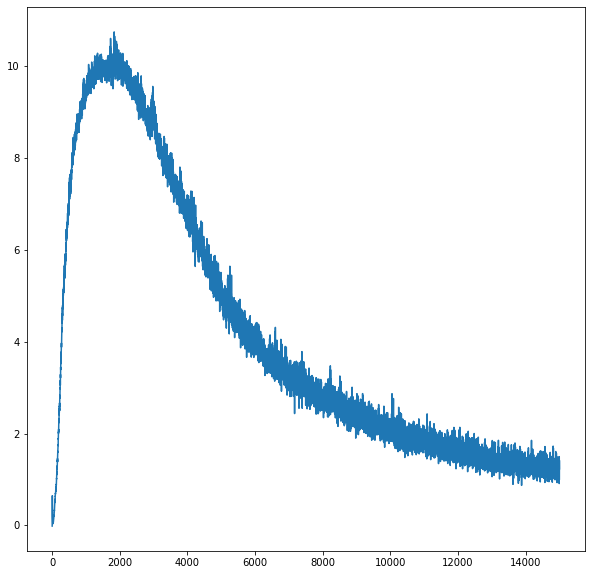

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

# Plot learned gradient field

In [7]:
import numpy as np

X = np.linspace(-4, 4, 30)
Y = np.linspace(-4, 4, 30)
n_sigma = sigmas.size(0)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device).expand(n_sigma, -1, -1)
grad_field = score_net(grid_tensor, sigmas)
grad_field_np = grad_field.detach().cpu().numpy()

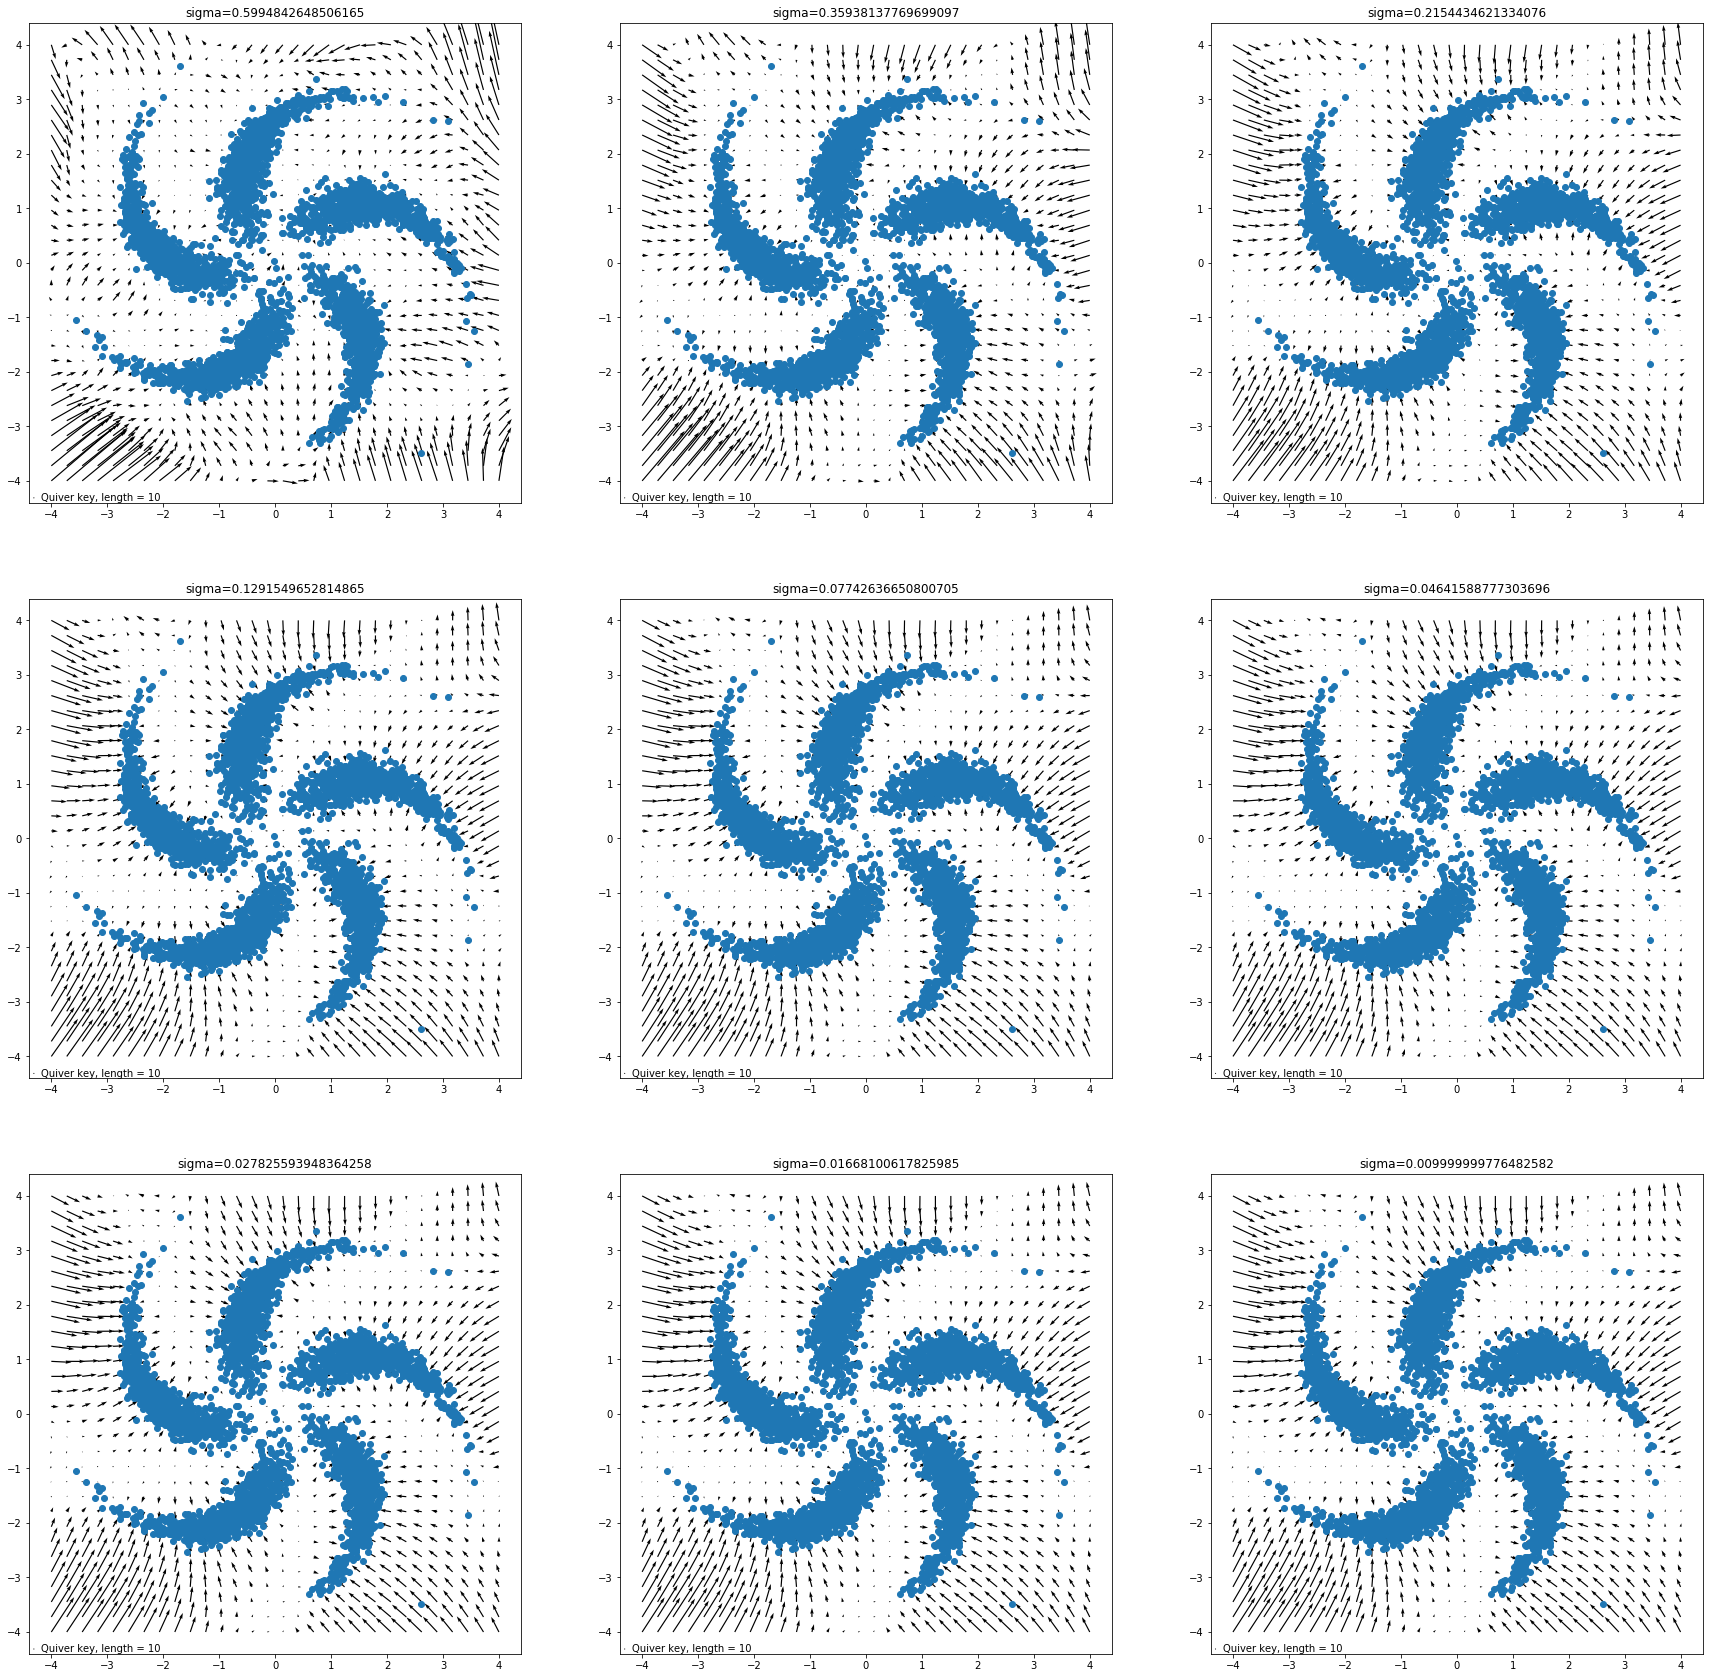

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
sample_data = toy_data.inf_train_gen('pinwheel', n_points=4096)
for i in range(n_sigma):
    q = ax[i // 3, i % 3].quiver(grid[..., 0], grid[..., 1], grad_field_np[i, :, 0], grad_field_np[i, :, 1])
    ax[i // 3, i % 3].quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
    ax[i // 3, i % 3].scatter(sample_data[:, 0], sample_data[:, 1])
    ax[i // 3, i % 3].set_title("sigma={}".format(sigmas[i].item()))

# Visualize sampling

In [140]:
def get_prior(num_points, inp_dim):
    return (torch.rand(num_points, inp_dim) * 2. - 1.) * 4

def langevin_dynamics(model, sigmas, num_points=2048, dim=2, eps=1*1e-3, num_steps=10):
    with torch.no_grad():
        x_list = []
        model.eval()
        x = get_prior(num_points, dim).unsqueeze(0).cuda()
        x_list.append(x.clone())
        for sigma in sigmas:
            alpha = eps * ((sigma / sigmas[-1]) ** 2)
            for t in range(num_steps):
                z_t = torch.randn_like(x)
                x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
                x_list.append(x.clone())
        return x, x_list
    
# def langevin_dynamics_lsd_test(f, l=1., e=.01, num_points=2048, n_steps=100, anneal=None):
#         x_k = get_prior(num_points, 2).cuda()
#         # sgld
#         if anneal == "lin":
#             lrs = list(reversed(np.linspace(e, l, n_steps)))
#         elif anneal == "log":
#             lrs = np.logspace(np.log10(l), np.log10(e))
#         else:
#             lrs = [l for _ in range(n_steps)]
#         x_k_list = [x_k.clone()]
#         for this_lr in lrs:
#             x_k += this_lr * f(x_k) + torch.randn_like(x_k) * e
#             x_k_list.append(x_k.clone())
#         final_samples = x_k.detach()
#         return final_samples, x_k_list

In [141]:
x_final, all_samples = langevin_dynamics(score_net, sigmas[0:], eps=1e-4, num_steps=20)
all_samples = [item.detach().cpu().squeeze().numpy() for item in all_samples]

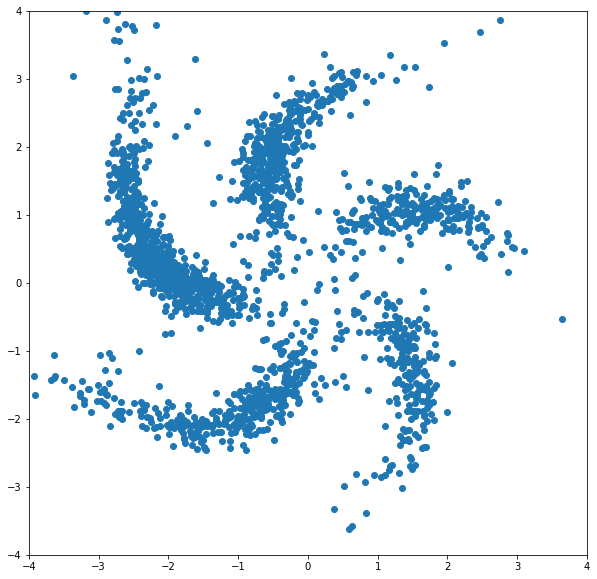

In [128]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)
ax1.scatter(all_samples[-1][:, 0], all_samples[-1][:, 1])

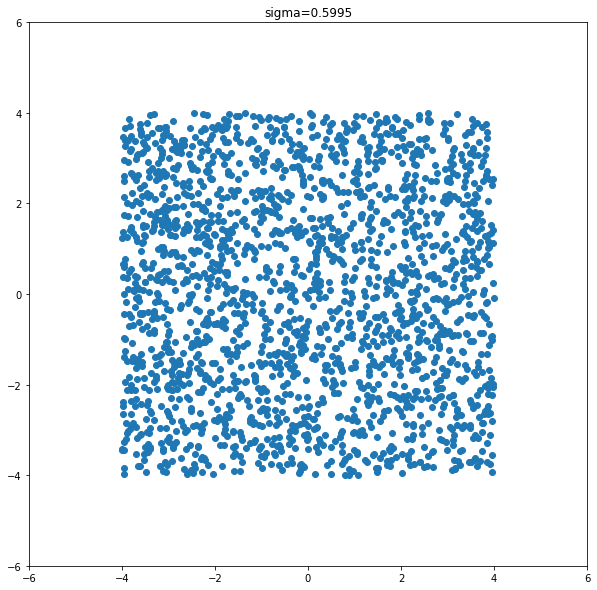

In [152]:
from matplotlib import animation, rc
rc('animation', html='html5')

def animate(i, data, scat):
    pts = data[i]
    scatter.set_offsets(pts)
    ax1.set_title("sigma={:.4f}".format(sigmas[i // 20].item()))
    return scatter,

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.set_title("sigma={:.4f}".format(sigmas[0].item()))
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)
initial_pts = all_samples[0]
scatter = ax1.scatter(initial_pts[:, 0], initial_pts[:, 1])
anim = animation.FuncAnimation(fig, animate, frames=range(len(all_samples) - 1),
                                  fargs=(all_samples, scatter), interval=200)
anim

In [147]:
len(all_samples)

181